In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
%pip install tensorflow matplotlib scikit-learn mediapipe opencv-python

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 61.0/61.0 kB 5.6 MB/s eta 0:00:00
INFO: pip is looking at multiple versions of opencv-python to determine which version is compatible with other requirements. This could take a while.
INFO: pip is looking at multiple versions of opencv-contrib-python to determine which version is compatible with other requirements. This could take a while.
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 35.6/35.6 MB 50.1 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 63.0/63.0 MB 10.3 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 18.0/18.0 MB 116.6 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 294.9/294.9 kB 31.7 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 69.1/69.1 MB 11.1 MB/s eta 0:00:00
  Attempting uninstall: protobuf
    Found existing installation: protobuf 5.29.5
    Uninstalling protobuf-5.29.5:
      Successfully uninstalled protobuf-5.29.5
  Attempting uninstall: numpy
    Found existing in

In [ ]:
%pip install --upgrade tensorflow keras

ERROR: Operation cancelled by user
^C


In [ ]:
import os, cv2, numpy as np
from pathlib import Path
#import mediapipe as mp
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers
import matplotlib.pyplot as plt
from sklearn.metrics import classification_report, confusion_matrix

print("TensorFlow:", tf.__version__)
print("Num GPUs Available:", len(tf.config.list_physical_devices('GPU')))

TensorFlow: 2.19.0
Num GPUs Available: 1


In [ ]:
cd drive/MyDrive/DLRV


/content/drive/MyDrive/DLRV


In [ ]:
DATA_ROOT = "/content/drive/MyDrive/DLRV/DATASET/DATASET"
TRAIN_DIR = str(Path(DATA_ROOT) / "TRAIN")
TEST_DIR  = str(Path(DATA_ROOT) / "TEST")

IMG_SIZE  = (224, 224)
BATCH     = 32
VAL_SPLIT = 0.20
SEED      = 42

assert Path(TRAIN_DIR).exists() and Path(TEST_DIR).exists(), "Check DATASET/TRAIN and DATASET/TEST paths."
print("Train path:", TRAIN_DIR)
print("Test  path:", TEST_DIR)

Train path: /content/drive/MyDrive/DLRV/DATASET/DATASET/TRAIN
Test  path: /content/drive/MyDrive/DLRV/DATASET/DATASET/TEST


In [ ]:
from PIL import Image, ImageFile
ImageFile.LOAD_TRUNCATED_IMAGES = True  # allow PIL to open some truncated imgs

VALID_EXTS = {".jpg", ".jpeg", ".png", ".bmp", ".gif"}
QUAR = Path(DATA_ROOT) / "_QUARANTINE"
QUAR.mkdir(exist_ok=True)

def find_bad_images(root: Path):
    bad = []
    for p in Path(root).rglob("*"):
        if p.is_file() and p.suffix.lower() in VALID_EXTS:
            try:
                raw = tf.io.read_file(str(p))
                # Let TF attempt a decode; will error on corrupt files
                _ = tf.io.decode_image(raw, channels=3)
            except Exception as e:
                bad.append((p, repr(e)))
    return bad

def try_fix(p: Path):
    # Re-open & re-save with PIL -> overwrite original as clean JPEG
    try:
        with Image.open(p) as im:
            im = im.convert("RGB")
            tmp = p.with_suffix(".repacked.jpg")
            im.save(tmp, "JPEG", quality=95, optimize=True)
        tmp.replace(p)
        return True
    except Exception:
        return False

def fix_or_quarantine(entries):
    fixed, moved = 0, 0
    for p, _ in entries:
        if try_fix(p):
            fixed += 1
        else:
            (QUAR / p.name).write_bytes(Path(p).read_bytes()) if p.exists() else None
            try:
                p.unlink(missing_ok=True)
            except Exception:
                pass
            moved += 1
    return fixed, moved

bad_train = find_bad_images(Path(TRAIN_DIR))
bad_test  = find_bad_images(Path(TEST_DIR))
print(f"Found bad files — TRAIN: {len(bad_train)} | TEST: {len(bad_test)}")
if bad_train[:3]: print("Sample bad TRAIN:", bad_train[:3])
if bad_test[:3]:  print("Sample bad TEST :", bad_test[:3])

fixed_t, moved_t = fix_or_quarantine(bad_train)
fixed_e, moved_e = fix_or_quarantine(bad_test)
print(f"Fix results — TRAIN fixed:{fixed_t} moved:{moved_t} | TEST fixed:{fixed_e} moved:{moved_e}")

# Re-scan to confirm
bad_train = find_bad_images(Path(TRAIN_DIR))
bad_test  = find_bad_images(Path(TEST_DIR))
print(f"After fix — bad TRAIN: {len(bad_train)} | bad TEST: {len(bad_test)}")


Found bad files — TRAIN: 0 | TEST: 0
Fix results — TRAIN fixed:0 moved:0 | TEST fixed:0 moved:0
After fix — bad TRAIN: 0 | bad TEST: 0


In [ ]:
train_raw = keras.utils.image_dataset_from_directory(
    TRAIN_DIR, image_size=IMG_SIZE, batch_size=BATCH,
    validation_split=VAL_SPLIT, subset='training',
    seed=SEED, label_mode='categorical'
)
val_raw = keras.utils.image_dataset_from_directory(
    TRAIN_DIR, image_size=IMG_SIZE, batch_size=BATCH,
    validation_split=VAL_SPLIT, subset='validation',
    seed=SEED, label_mode='categorical'
)
test_raw = keras.utils.image_dataset_from_directory(
    TEST_DIR, image_size=IMG_SIZE, batch_size=BATCH,
    shuffle=False, label_mode='categorical'
)

# ✅ Grab class_names NOW (not later)
class_names = train_raw.class_names
num_classes = len(class_names)
print("Classes:", class_names, "| num_classes:", num_classes)

# Make the pipeline drop any sample that errors during iteration
def safe_ignore_errors(ds):
    try:
        return ds.ignore_errors()  # TF >= 2.16 recommended
    except AttributeError:
        # Fallback for older TF: experimental API
        return ds.apply(tf.data.experimental.ignore_errors())

train_ds = safe_ignore_errors(train_raw)
val_ds   = safe_ignore_errors(val_raw)
test_ds  = safe_ignore_errors(test_raw)

AUTOTUNE = tf.data.AUTOTUNE
train_ds = train_ds.cache().shuffle(1000).prefetch(AUTOTUNE)
val_ds   = val_ds.cache().prefetch(AUTOTUNE)
test_ds  = test_ds.cache().prefetch(AUTOTUNE)


Found 1081 files belonging to 5 classes.
Using 865 files for training.
Found 1081 files belonging to 5 classes.
Using 216 files for validation.
Found 470 files belonging to 5 classes.
Classes: ['downdog', 'goddess', 'plank', 'tree', 'warrior2'] | num_classes: 5


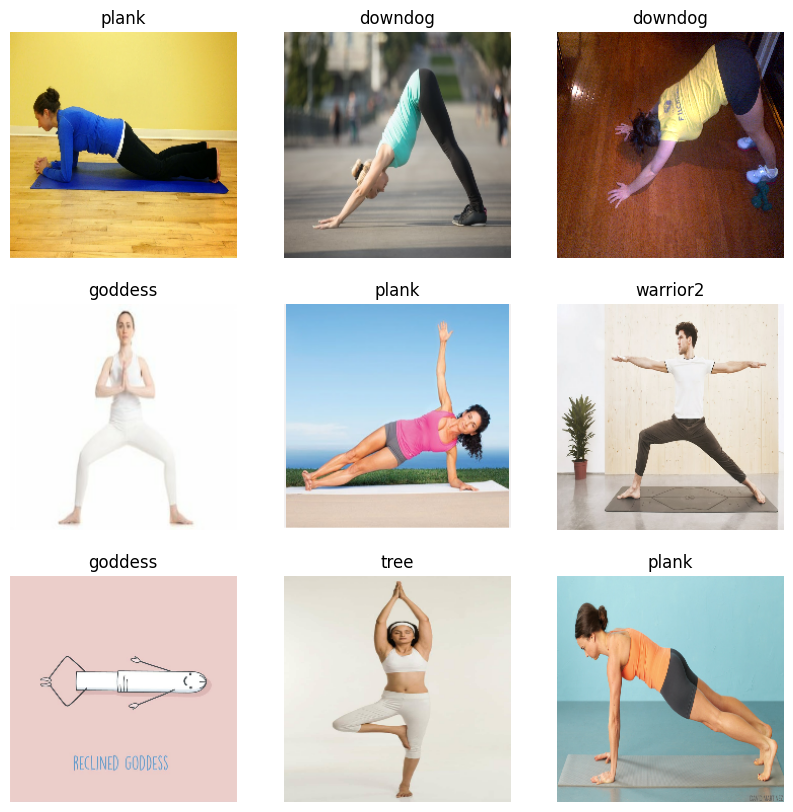

In [ ]:
for images, labels in train_ds.take(1):
    plt.figure(figsize=(10,10))
    n = min(9, images.shape[0])
    for i in range(n):
        ax = plt.subplot(3,3,i+1)
        plt.imshow(images[i].numpy().astype("uint8"))
        # label_mode='categorical' -> one-hot
        idx = int(tf.argmax(labels[i]).numpy())
        plt.title(class_names[idx])
        plt.axis("off")
    plt.show()


In [ ]:
def plot_curves(history, title="Training Curves"):
    h = history.history
    plt.figure(figsize=(10,4)); plt.plot(h['loss']); plt.plot(h['val_loss']);
    plt.title(title+" — Loss"); plt.legend(['loss','val_loss']); plt.xlabel('epoch'); plt.show()
    plt.figure(figsize=(10,4)); plt.plot(h['accuracy']); plt.plot(h['val_accuracy']);
    plt.title(title+" — Accuracy"); plt.legend(['acc','val_acc']); plt.xlabel('epoch'); plt.show()

def evaluate_model(model, test_ds, class_names):
    y_true, y_pred = [], []
    for x, y in test_ds:
        p = model.predict(x, verbose=0)
        y_pred.append(np.argmax(p, axis=1))
        y_true.append(np.argmax(y.numpy(), axis=1))
    y_pred = np.concatenate(y_pred); y_true = np.concatenate(y_true)
    print(classification_report(y_true, y_pred, target_names=class_names, digits=4))

    cm = confusion_matrix(y_true, y_pred, normalize='true')
    plt.figure(figsize=(0.8*len(class_names)+3, 0.8*len(class_names)+3))
    plt.imshow(cm, interpolation='nearest'); plt.title("Confusion Matrix (normalized)")
    plt.colorbar(); ticks = np.arange(len(class_names))
    plt.xticks(ticks, class_names, rotation=45, ha='right'); plt.yticks(ticks, class_names)
    thr = cm.max()/2
    for i,j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        plt.text(j, i, f"{cm[i,j]:.2f}", ha="center", va="center",
                 color="white" if cm[i,j] > thr else "black")
    plt.ylabel('True'); plt.xlabel('Predicted'); plt.tight_layout(); plt.show()

def mixup(ds, alpha=0.2):
    def sample_beta(n):
        g1 = tf.random.gamma([n], alpha); g2 = tf.random.gamma([n], alpha)
        return g1 / (g1 + g2)
    def _mix(a, b):
        (x1, y1), (x2, y2) = a, b
        n = tf.shape(x1)[0]
        lam = tf.reshape(sample_beta(n), (n,1,1,1))
        lam_y = tf.reshape(tf.squeeze(lam, axis=[2,3]), (n,1))
        return lam*x1 + (1-lam)*x2, lam_y*y1 + (1-lam_y)*y2
    return tf.data.Dataset.zip((ds, ds)).map(_mix, num_parallel_calls=AUTOTUNE)


VGG-16

In [ ]:
from tensorflow.keras.applications import VGG16
from tensorflow.keras.applications.vgg16 import preprocess_input
from tensorflow import keras
from tensorflow.keras import layers
import numpy as np
import matplotlib.pyplot as plt

# Keep aug light; turn OFF flip if left/right matters in your classes
USE_FLIP = False
data_augmentation_vgg = keras.Sequential(
    [layers.RandomRotation(0.05),
     layers.RandomZoom(0.05),
     layers.RandomContrast(0.05)] +
    ([layers.RandomFlip("horizontal")] if USE_FLIP else []),
    name="aug_vgg"
)


In [ ]:
def build_vgg16_classifier(num_classes, train_base=False, dropout=0.3):
    # ImageNet backbone
    base = VGG16(weights="imagenet", include_top=False, input_shape=(224,224,3))
    base.trainable = train_base  # freeze for the first phase

    inputs = layers.Input(shape=(224,224,3))
    x = data_augmentation_vgg(inputs)
    # VGG16 preprocessing expects float in [0,255]; make sure dtype is float32
    x = layers.Lambda(lambda t: tf.cast(t, tf.float32))(x)
    x = layers.Lambda(preprocess_input, name="vgg16_prep")(x)

    # Pass through backbone (no BN layers in VGG16, so training=False not critical)
    x = base(x, training=False)
    x = layers.GlobalAveragePooling2D()(x)
    x = layers.Dropout(dropout)(x)
    outputs = layers.Dense(num_classes, activation="softmax")(x)
    model = keras.Model(inputs, outputs, name="VGG16_transfer")
    return model, base

vgg_model, vgg_base = build_vgg16_classifier(num_classes, train_base=False, dropout=0.35)

vgg_model.compile(
    optimizer=keras.optimizers.Adam(learning_rate=1e-3),
    loss=keras.losses.CategoricalCrossentropy(),
    metrics=["accuracy"]
)
vgg_model.summary()


58889256/58889256 ━━━━━━━━━━━━━━━━━━━━ 2s 0us/step


Model: "VGG16_transfer"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ input_layer_7 (InputLayer)      │ (None, 224, 224, 3)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ aug_vgg (Sequential)            │ (None, 224, 224, 3)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ lambda (Lambda)                 │ (None, 224, 224, 3)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ vgg16_prep (Lambda)             │ (None, 224, 224, 3)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ vgg16 (Functional)              │ (None, 7, 7, 512)      │    14,714,688 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ global_average_pooling2d_14     │ (None, 512)            │             0 │
│ (GlobalAveragePooling2D)        │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_2 (Dropout)             │ (None, 512)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_30 (Dense)                │ (None, 5)              │         2,565 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 14,717,253 (56.14 MB)

 Trainable params: 2,565 (10.02 KB)

 Non-trainable params: 14,714,688 (56.13 MB)

Epoch 1/12
28/28 ━━━━━━━━━━━━━━━━━━━━ 12s 282ms/step - accuracy: 0.2169 - loss: 5.9769 - val_accuracy: 0.2685 - val_loss: 3.8291
Epoch 2/12
28/28 ━━━━━━━━━━━━━━━━━━━━ 4s 157ms/step - accuracy: 0.3249 - loss: 3.8703 - val_accuracy: 0.3981 - val_loss: 2.7421
Epoch 3/12
28/28 ━━━━━━━━━━━━━━━━━━━━ 10s 348ms/step - accuracy: 0.3607 - loss: 3.2526 - val_accuracy: 0.5000 - val_loss: 2.0689
Epoch 4/12
28/28 ━━━━━━━━━━━━━━━━━━━━ 5s 158ms/step - accuracy: 0.4489 - loss: 2.6330 - val_accuracy: 0.5648 - val_loss: 1.6979
Epoch 5/12
28/28 ━━━━━━━━━━━━━━━━━━━━ 5s 183ms/step - accuracy: 0.5030 - loss: 2.0729 - val_accuracy: 0.6528 - val_loss: 1.3272
Epoch 6/12
28/28 ━━━━━━━━━━━━━━━━━━━━ 4s 156ms/step - accuracy: 0.5879 - loss: 1.7216 - val_accuracy: 0.6806 - val_loss: 1.2421
Epoch 7/12
28/28 ━━━━━━━━━━━━━━━━━━━━ 10s 348ms/step - accuracy: 0.6296 - loss: 1.5599 - val_accuracy: 0.7176 - val_loss: 1.0001
Epoch 8/12
28/28 ━━━━━━━━━━━━━━━━━━━━ 4s 141ms/step - accuracy: 0.6378 - loss: 1.3192 - val_accuracy:

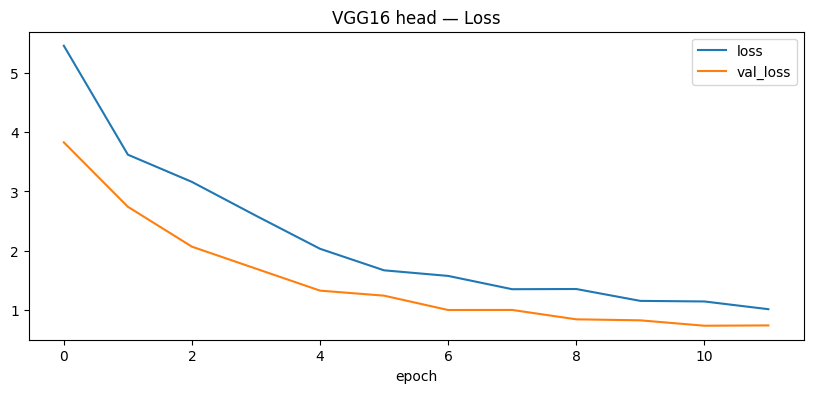

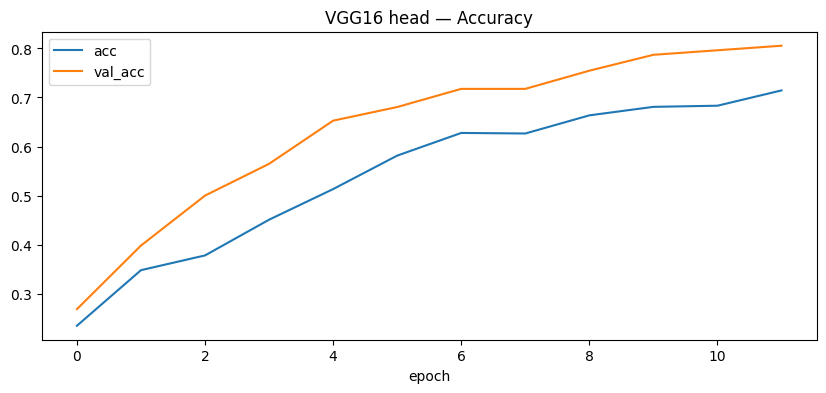

In [ ]:
EPOCHS_HEAD = 12
hist_head = vgg_model.fit(
    train_ds, validation_data=val_ds, epochs=EPOCHS_HEAD,
    callbacks=[
        keras.callbacks.ModelCheckpoint("vgg16_head.keras", save_best_only=True, monitor="val_accuracy"),
        keras.callbacks.EarlyStopping(monitor="val_accuracy", patience=5, restore_best_weights=True)
    ],
    verbose=1
)

# Curves
h = hist_head.history
plt.figure(figsize=(10,4)); plt.plot(h['loss']); plt.plot(h['val_loss']); plt.title("VGG16 head — Loss"); plt.legend(['loss','val_loss']); plt.xlabel('epoch'); plt.show()
plt.figure(figsize=(10,4)); plt.plot(h['accuracy']); plt.plot(h['val_accuracy']); plt.title("VGG16 head — Accuracy"); plt.legend(['acc','val_acc']); plt.xlabel('epoch'); plt.show()


Epoch 1/15
28/28 ━━━━━━━━━━━━━━━━━━━━ 9s 216ms/step - accuracy: 0.7038 - loss: 0.9648 - val_accuracy: 0.8472 - val_loss: 0.6151
Epoch 2/15
28/28 ━━━━━━━━━━━━━━━━━━━━ 5s 189ms/step - accuracy: 0.7824 - loss: 0.6653 - val_accuracy: 0.8611 - val_loss: 0.5545
Epoch 3/15
28/28 ━━━━━━━━━━━━━━━━━━━━ 5s 187ms/step - accuracy: 0.8558 - loss: 0.4338 - val_accuracy: 0.8750 - val_loss: 0.5426
Epoch 4/15
28/28 ━━━━━━━━━━━━━━━━━━━━ 10s 377ms/step - accuracy: 0.8782 - loss: 0.3609 - val_accuracy: 0.8843 - val_loss: 0.5251
Epoch 5/15
28/28 ━━━━━━━━━━━━━━━━━━━━ 20s 374ms/step - accuracy: 0.8734 - loss: 0.3601 - val_accuracy: 0.8889 - val_loss: 0.4862
Epoch 6/15
28/28 ━━━━━━━━━━━━━━━━━━━━ 15s 190ms/step - accuracy: 0.8824 - loss: 0.3559 - val_accuracy: 0.8935 - val_loss: 0.4640
Epoch 7/15
28/28 ━━━━━━━━━━━━━━━━━━━━ 5s 192ms/step - accuracy: 0.9081 - loss: 0.2695 - val_accuracy: 0.9028 - val_loss: 0.4630
Epoch 8/15
28/28 ━━━━━━━━━━━━━━━━━━━━ 9s 163ms/step - accuracy: 0.9320 - loss: 0.2051 - val_accuracy:

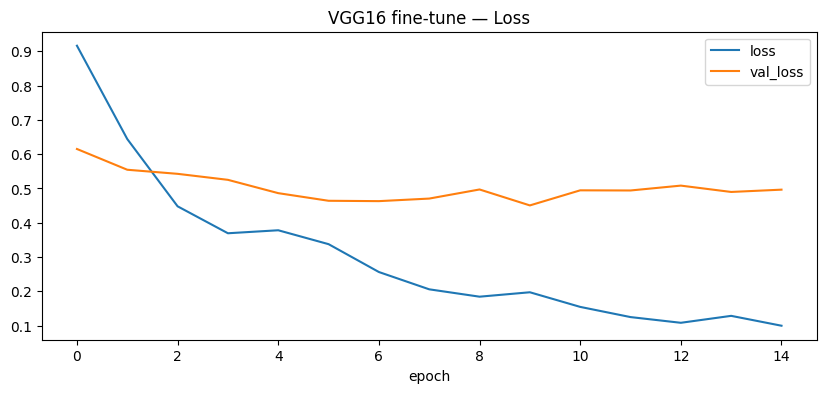

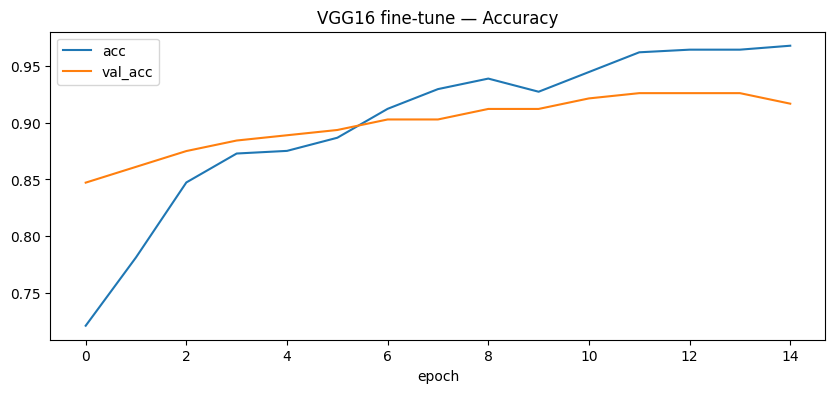

In [ ]:
# Unfreeze only block5_* layers for fine-tuning
for layer in vgg_base.layers:
    layer.trainable = layer.name.startswith("block5")

vgg_model.compile(
    optimizer=keras.optimizers.Adam(learning_rate=1e-5),
    loss=keras.losses.CategoricalCrossentropy(),
    metrics=["accuracy"]
)

EPOCHS_FT = 15
hist_ft = vgg_model.fit(
    train_ds, validation_data=val_ds, epochs=EPOCHS_FT,
    callbacks=[
        keras.callbacks.ModelCheckpoint("vgg16_finetuned.keras", save_best_only=True, monitor="val_accuracy"),
        keras.callbacks.EarlyStopping(monitor="val_accuracy", patience=6, restore_best_weights=True)
    ],
    verbose=1
)

# Curves
h = hist_ft.history
plt.figure(figsize=(10,4)); plt.plot(h['loss']); plt.plot(h['val_loss']); plt.title("VGG16 fine-tune — Loss"); plt.legend(['loss','val_loss']); plt.xlabel('epoch'); plt.show()
plt.figure(figsize=(10,4)); plt.plot(h['accuracy']); plt.plot(h['val_accuracy']); plt.title("VGG16 fine-tune — Accuracy"); plt.legend(['acc','val_acc']); plt.xlabel('epoch'); plt.show()


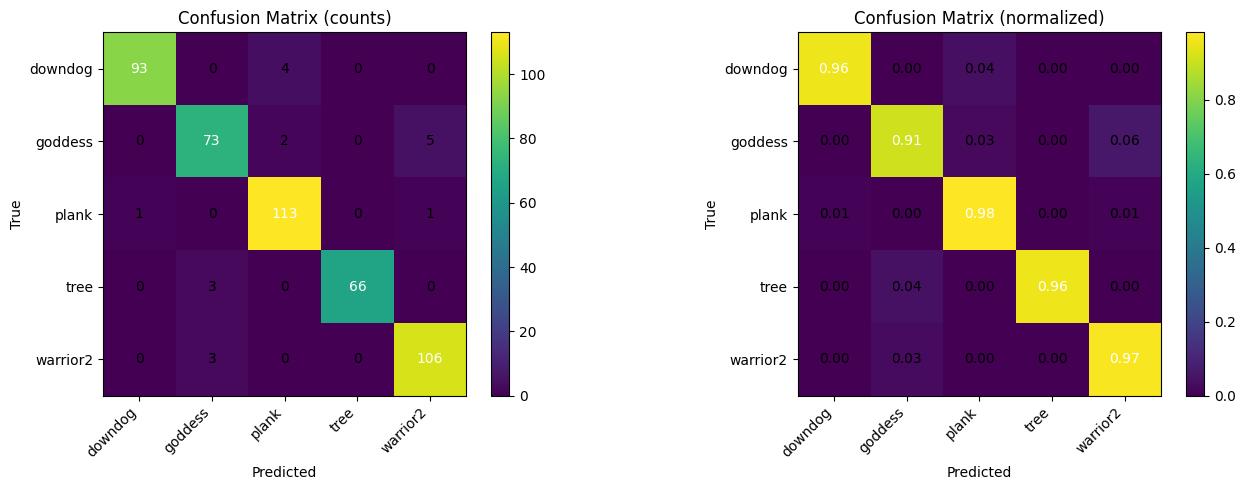

,precision,recall,f1-score,support
downdog,0.9894,0.9588,0.9738,97.0000
goddess,0.9241,0.9125,0.9182,80.0000
plank,0.9496,0.9826,0.9658,115.0000
tree,1.0000,0.9565,0.9778,69.0000
warrior2,0.9464,0.9725,0.9593,109.0000
accuracy,0.9596,0.9596,0.9596,0.9596
macro avg,0.9619,0.9566,0.9590,470.0000
weighted avg,0.9601,0.9596,0.9596,470.0000


Saved: classification_report_vgg16.csv


In [ ]:
import pandas as pd
from sklearn.metrics import classification_report, confusion_matrix

# Pick the best VGG model (after fine-tune)
eval_model = vgg_model

y_true, y_pred = [], []
for xb, yb in test_ds:
    p = eval_model.predict(xb, verbose=0)
    y_pred.append(np.argmax(p, axis=1))
    y_true.append(np.argmax(yb.numpy(), axis=1))
y_pred = np.concatenate(y_pred); y_true = np.concatenate(y_true)

cm  = confusion_matrix(y_true, y_pred, labels=range(num_classes))
cmn = confusion_matrix(y_true, y_pred, labels=range(num_classes), normalize='true')

fig, axes = plt.subplots(1, 2, figsize=(14,5))
im0 = axes[0].imshow(cm);  axes[0].set_title("Confusion Matrix (counts)")
axes[0].set_xlabel("Predicted"); axes[0].set_ylabel("True")
axes[0].set_xticks(range(num_classes)); axes[0].set_yticks(range(num_classes))
axes[0].set_xticklabels(class_names, rotation=45, ha='right'); axes[0].set_yticklabels(class_names)
plt.colorbar(im0, ax=axes[0], fraction=0.046, pad=0.04)
for i in range(num_classes):
    for j in range(num_classes):
        axes[0].text(j, i, cm[i, j], ha='center', va='center',
                     color='white' if cm[i,j] > cm.max()/2 else 'black')

im1 = axes[1].imshow(cmn); axes[1].set_title("Confusion Matrix (normalized)")
axes[1].set_xlabel("Predicted"); axes[1].set_ylabel("True")
axes[1].set_xticks(range(num_classes)); axes[1].set_yticks(range(num_classes))
axes[1].set_xticklabels(class_names, rotation=45, ha='right'); axes[1].set_yticklabels(class_names)
plt.colorbar(im1, ax=axes[1], fraction=0.046, pad=0.04)
for i in range(num_classes):
    for j in range(num_classes):
        axes[1].text(j, i, f"{cmn[i, j]:.2f}", ha='center', va='center',
                     color='white' if cmn[i,j] > cmn.max()/2 else 'black')
plt.tight_layout(); plt.show()

report = classification_report(y_true, y_pred, target_names=class_names, output_dict=True, digits=4)
df_report = pd.DataFrame(report).transpose()
display(df_report.style.format(precision=4))
df_report.to_csv("classification_report_vgg16.csv", index=True)
print("Saved: classification_report_vgg16.csv")


Using Media Pipe

In [ ]:
import cv2, numpy as np
import mediapipe as mp

In [ ]:
mp_pose = mp.solutions.pose
mp_drawing = mp.solutions.drawing_utils
mp_styles = mp.solutions.drawing_styles

def skeletonize_image_bgr(img_bgr, out_size=(224,224)):
    img_rgb = cv2.cvtColor(img_bgr, cv2.COLOR_BGR2RGB)
    h, w = img_rgb.shape[:2]
    canvas = np.zeros((h, w, 3), dtype=np.uint8)
    # Static image mode is correct for files; creates a fresh Pose object per image
    with mp_pose.Pose(static_image_mode=True) as pose:
        res = pose.process(img_rgb)
        if res.pose_landmarks:
            mp_drawing.draw_landmarks(
                image=canvas,
                landmark_list=res.pose_landmarks,
                connections=mp_pose.POSE_CONNECTIONS,
                landmark_drawing_spec=mp_styles.get_default_pose_landmarks_style()
            )
    if out_size:
        canvas = cv2.resize(canvas, out_size, interpolation=cv2.INTER_AREA)
    return canvas

def skeletonize_folder(src_root, dst_root, out_ext=".jpg"):
    src_root, dst_root = Path(src_root), Path(dst_root)
    classes = sorted([d.name for d in src_root.iterdir() if d.is_dir()])
    for cls in classes:
        (Path(dst_root)/cls).mkdir(parents=True, exist_ok=True)

    written = skipped = 0
    for cls in classes:
        for p in (src_root/cls).rglob("*"):
            if p.suffix.lower() in {".jpg",".jpeg",".png",".bmp",".gif"} and p.is_file():
                try:
                    img = cv2.imread(str(p))
                    if img is None:
                        skipped += 1; continue
                    skel = skeletonize_image_bgr(img, IMG_SIZE)
                    out_path = (Path(dst_root)/cls/p.stem).with_suffix(out_ext)
                    cv2.imwrite(str(out_path), skel, [cv2.IMWRITE_JPEG_QUALITY, 95])
                    written += 1
                except Exception:
                    skipped += 1
    return classes, written, skipped


In [ ]:

from pathlib import Path

if "TRAIN_DIR" not in globals() or "TEST_DIR" not in globals():
    DATA_ROOT = "/content/DATASET"  # <-- change if needed
    TRAIN_DIR = str(Path(DATA_ROOT) / "TRAIN")
    TEST_DIR  = str(Path(DATA_ROOT) / "TEST")

SKEL_ROOT  = "/content/DATASET_SKELETON"   # where we'll write skeleton images
SKEL_TRAIN = str(Path(SKEL_ROOT) / "TRAIN")
SKEL_TEST  = str(Path(SKEL_ROOT) / "TEST")
IMG_SIZE   = (224, 224)                     # VGG16 size

# Ensure folders exist
Path(SKEL_TRAIN).mkdir(parents=True, exist_ok=True)
Path(SKEL_TEST).mkdir(parents=True, exist_ok=True)

print("SKEL_TRAIN:", SKEL_TRAIN)
print("SKEL_TEST :", SKEL_TEST)


SKEL_TRAIN: /content/DATASET_SKELETON/TRAIN
SKEL_TEST : /content/DATASET_SKELETON/TEST


In [ ]:
skel_classes_train, n_train_written, n_train_skipped = skeletonize_folder(TRAIN_DIR, SKEL_TRAIN)
skel_classes_test,  n_test_written,  n_test_skipped  = skeletonize_folder(TEST_DIR,  SKEL_TEST)
assert skel_classes_train == skel_classes_test, "Train/Test class folders differ."

skel_class_names = skel_classes_train
skel_num_classes = len(skel_class_names)
print("Classes:", skel_class_names)
print(f"TRAIN skeletons: wrote {n_train_written}, skipped {n_train_skipped}")
print(f"TEST  skeletons: wrote {n_test_written},  skipped {n_test_skipped}")


Classes: ['downdog', 'goddess', 'plank', 'tree', 'warrior2']
TRAIN skeletons: wrote 1081, skipped 0
TEST  skeletons: wrote 470,  skipped 0


In [ ]:
# If the function isn't in memory (after a restart), re-define a minimal version:
try:
    skeletonize_folder
except NameError:
    import cv2, numpy as np, mediapipe as mp
    mp_pose = mp.solutions.pose
    mp_drawing = mp.solutions.drawing_utils
    mp_styles = mp.solutions.drawing_styles

    def skeletonize_image_bgr(img_bgr, out_size=(224,224)):
        img_rgb = cv2.cvtColor(img_bgr, cv2.COLOR_BGR2RGB)
        h, w = img_rgb.shape[:2]
        canvas = np.zeros((h, w, 3), dtype=np.uint8)
        with mp_pose.Pose(static_image_mode=True) as pose:
            res = pose.process(img_rgb)
            if res.pose_landmarks:
                mp_drawing.draw_landmarks(
                    image=canvas,
                    landmark_list=res.pose_landmarks,
                    connections=mp_pose.POSE_CONNECTIONS,
                    landmark_drawing_spec=mp_styles.get_default_pose_landmarks_style()
                )
        return cv2.resize(canvas, out_size, interpolation=cv2.INTER_AREA)

    def skeletonize_folder(src_root, dst_root, out_ext=".jpg"):
        src_root, dst_root = Path(src_root), Path(dst_root)
        classes = sorted([d.name for d in src_root.iterdir() if d.is_dir()])
        for cls in classes:
            (Path(dst_root)/cls).mkdir(parents=True, exist_ok=True)
        written = skipped = 0
        for cls in classes:
            for p in (src_root/cls).rglob("*"):
                if p.suffix.lower() in {".jpg",".jpeg",".png",".bmp",".gif"} and p.is_file():
                    try:
                        img = cv2.imread(str(p))
                        if img is None: skipped += 1; continue
                        skel = skeletonize_image_bgr(img, IMG_SIZE)
                        out_path = (Path(dst_root)/cls/p.stem).with_suffix(out_ext)
                        cv2.imwrite(str(out_path), skel, [cv2.IMWRITE_JPEG_QUALITY, 95])
                        written += 1
                    except Exception:
                        skipped += 1
        return classes, written, skipped

# Now run the skeletonization
skel_classes_train, n_train_written, n_train_skipped = skeletonize_folder(TRAIN_DIR, SKEL_TRAIN)
skel_classes_test,  n_test_written,  n_test_skipped  = skeletonize_folder(TEST_DIR,  SKEL_TEST)
assert skel_classes_train == skel_classes_test, "Train/Test class folders differ."

skel_class_names = skel_classes_train
skel_num_classes = len(skel_class_names)
print("Classes:", skel_class_names)
print(f"TRAIN skeletons: wrote {n_train_written}, skipped {n_train_skipped}")
print(f"TEST  skeletons: wrote {n_test_written}, skipped {n_test_skipped}")


Classes: ['downdog', 'goddess', 'plank', 'tree', 'warrior2']
TRAIN skeletons: wrote 1081, skipped 0
TEST  skeletons: wrote 470, skipped 0


In [ ]:
# Uses SKEL_TRAIN / SKEL_TEST defined earlier
from tensorflow import keras
from tensorflow.keras import layers
import tensorflow as tf
from pathlib import Path

IMG_SIZE = (224, 224)
BATCH    = 32
VAL_SPLIT= 0.20
SEED     = 42

skel_train_raw = keras.utils.image_dataset_from_directory(
    SKEL_TRAIN, image_size=IMG_SIZE, batch_size=BATCH,
    validation_split=VAL_SPLIT, subset='training',
    seed=SEED, label_mode='categorical'
)
skel_val_raw = keras.utils.image_dataset_from_directory(
    SKEL_TRAIN, image_size=IMG_SIZE, batch_size=BATCH,
    validation_split=VAL_SPLIT, subset='validation',
    seed=SEED, label_mode='categorical'
)
skel_test_raw = keras.utils.image_dataset_from_directory(
    SKEL_TEST, image_size=IMG_SIZE, batch_size=BATCH,
    shuffle=False, label_mode='categorical'
)

skel_class_names = skel_train_raw.class_names
skel_num_classes = len(skel_class_names)
print("Classes:", skel_class_names, "| num_classes:", skel_num_classes)

def safe_ignore_errors(ds):
    try:    return ds.ignore_errors()  # TF ≥ 2.16
    except: return ds.apply(tf.data.experimental.ignore_errors())  # fallback

AUTOTUNE = tf.data.AUTOTUNE
skel_train_ds = safe_ignore_errors(skel_train_raw).cache().shuffle(1000).prefetch(AUTOTUNE)
skel_val_ds   = safe_ignore_errors(skel_val_raw).cache().prefetch(AUTOTUNE)
skel_test_ds  = safe_ignore_errors(skel_test_raw).cache().prefetch(AUTOTUNE)


Found 1081 files belonging to 5 classes.
Using 865 files for training.
Found 1081 files belonging to 5 classes.
Using 216 files for validation.
Found 470 files belonging to 5 classes.
Classes: ['downdog', 'goddess', 'plank', 'tree', 'warrior2'] | num_classes: 5


In [ ]:
from tensorflow.keras.applications import VGG16
from tensorflow.keras.applications.vgg16 import preprocess_input

from tensorflow import keras
from tensorflow.keras import layers
import tensorflow as tf

# Keep flip OFF unless left/right doesn’t change the class label
USE_FLIP = False
data_augmentation_vgg = keras.Sequential(
    [layers.RandomRotation(0.05),
     layers.RandomZoom(0.05),
     layers.RandomContrast(0.05)] +
    ([layers.RandomFlip("horizontal")] if USE_FLIP else []),
    name="aug_vgg"
)

def build_vgg16_skeleton_classifier(num_classes, train_base=False, dropout=0.35):
    base = VGG16(weights="imagenet", include_top=False, input_shape=(224,224,3))
    base.trainable = train_base  # frozen for head training

    inputs = layers.Input(shape=(224,224,3))
    x = data_augmentation_vgg(inputs)
    x = layers.Lambda(lambda t: tf.cast(t, tf.float32))(x)
    # IMPORTANT: VGG16 expects its own preprocess_input (RGB->BGR + channel-wise zero-centering; no 1/255 scaling)
    x = layers.Lambda(preprocess_input, name="vgg16_preprocess")(x)

    x = base(x, training=False)
    x = layers.GlobalAveragePooling2D()(x)
    x = layers.Dropout(dropout)(x)
    outputs = layers.Dense(num_classes, activation="softmax")(x)
    return keras.Model(inputs, outputs, name="VGG16_on_skeletons"), base

vgg_skel, vgg_skel_base = build_vgg16_skeleton_classifier(skel_num_classes, train_base=False, dropout=0.35)
vgg_skel.compile(optimizer=keras.optimizers.Adam(1e-3),
                 loss=keras.losses.CategoricalCrossentropy(),
                 metrics=["accuracy"])
vgg_skel.summary()


58889256/58889256 ━━━━━━━━━━━━━━━━━━━━ 2s 0us/step


Model: "VGG16_on_skeletons"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ input_layer_1 (InputLayer)      │ (None, 224, 224, 3)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ aug_vgg (Sequential)            │ (None, 224, 224, 3)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ lambda (Lambda)                 │ (None, 224, 224, 3)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ vgg16_preprocess (Lambda)       │ (None, 224, 224, 3)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ vgg16 (Functional)              │ (None, 7, 7, 512)      │    14,714,688 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ global_average_pooling2d        │ (None, 512)            │             0 │
│ (GlobalAveragePooling2D)        │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout (Dropout)               │ (None, 512)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 5)              │         2,565 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 14,717,253 (56.14 MB)

 Trainable params: 2,565 (10.02 KB)

 Non-trainable params: 14,714,688 (56.13 MB)

In [ ]:
EPOCHS_HEAD = 12
hist_skel_head = vgg_skel.fit(
    skel_train_ds, validation_data=skel_val_ds, epochs=EPOCHS_HEAD,
    callbacks=[
        keras.callbacks.ModelCheckpoint("vgg16_skeletons_head.keras", save_best_only=True, monitor="val_accuracy"),
        keras.callbacks.EarlyStopping(monitor="val_accuracy", patience=5, restore_best_weights=True)
    ],
    verbose=1
)


Epoch 1/12
     28/Unknown 15s 132ms/step - accuracy: 0.1702 - loss: 4.7313

/usr/local/lib/python3.12/dist-packages/keras/src/trainers/epoch_iterator.py:160: UserWarning: Your input ran out of data; interrupting training. Make sure that your dataset or generator can generate at least `steps_per_epoch * epochs` batches. You may need to use the `.repeat()` function when building your dataset.
  self._interrupted_warning()


28/28 ━━━━━━━━━━━━━━━━━━━━ 19s 279ms/step - accuracy: 0.1715 - loss: 4.7085 - val_accuracy: 0.3333 - val_loss: 2.4967
Epoch 2/12
28/28 ━━━━━━━━━━━━━━━━━━━━ 4s 155ms/step - accuracy: 0.3201 - loss: 2.8410 - val_accuracy: 0.5833 - val_loss: 1.2957
Epoch 3/12
28/28 ━━━━━━━━━━━━━━━━━━━━ 10s 346ms/step - accuracy: 0.4596 - loss: 1.8646 - val_accuracy: 0.6574 - val_loss: 1.1150
Epoch 4/12
28/28 ━━━━━━━━━━━━━━━━━━━━ 4s 157ms/step - accuracy: 0.5361 - loss: 1.5189 - val_accuracy: 0.7315 - val_loss: 0.8409
Epoch 5/12
28/28 ━━━━━━━━━━━━━━━━━━━━ 5s 157ms/step - accuracy: 0.6000 - loss: 1.2358 - val_accuracy: 0.7407 - val_loss: 0.7814
Epoch 6/12
28/28 ━━━━━━━━━━━━━━━━━━━━ 4s 156ms/step - accuracy: 0.6952 - loss: 0.8530 - val_accuracy: 0.7685 - val_loss: 0.7035
Epoch 7/12
28/28 ━━━━━━━━━━━━━━━━━━━━ 10s 348ms/step - accuracy: 0.7060 - loss: 0.8482 - val_accuracy: 0.7731 - val_loss: 0.6403
Epoch 8/12
28/28 ━━━━━━━━━━━━━━━━━━━━ 5s 161ms/step - accuracy: 0.6926 - loss: 0.8334 - val_accuracy: 0.7917 - v

In [ ]:
# Unfreeze only block5_* for careful fine-tuning
for layer in vgg_skel_base.layers:
    layer.trainable = layer.name.startswith("block5")

vgg_skel.compile(
    optimizer=keras.optimizers.Adam(learning_rate=1e-5),
    loss=keras.losses.CategoricalCrossentropy(),
    metrics=["accuracy"]
)

EPOCHS_FT = 15
hist_skel_ft = vgg_skel.fit(
    skel_train_ds, validation_data=skel_val_ds, epochs=EPOCHS_FT,
    callbacks=[
        keras.callbacks.ModelCheckpoint("vgg16_skeletons_finetuned.keras", save_best_only=True, monitor="val_accuracy"),
        keras.callbacks.EarlyStopping(monitor="val_accuracy", patience=6, restore_best_weights=True)
    ],
    verbose=1
)


Epoch 1/15
28/28 ━━━━━━━━━━━━━━━━━━━━ 9s 234ms/step - accuracy: 0.8215 - loss: 0.5202 - val_accuracy: 0.8843 - val_loss: 0.4113
Epoch 2/15
28/28 ━━━━━━━━━━━━━━━━━━━━ 5s 181ms/step - accuracy: 0.8724 - loss: 0.3656 - val_accuracy: 0.8611 - val_loss: 0.4664
Epoch 3/15
28/28 ━━━━━━━━━━━━━━━━━━━━ 6s 207ms/step - accuracy: 0.8797 - loss: 0.3741 - val_accuracy: 0.8889 - val_loss: 0.3435
Epoch 4/15
28/28 ━━━━━━━━━━━━━━━━━━━━ 10s 179ms/step - accuracy: 0.9137 - loss: 0.2642 - val_accuracy: 0.8889 - val_loss: 0.3318
Epoch 5/15
28/28 ━━━━━━━━━━━━━━━━━━━━ 5s 178ms/step - accuracy: 0.9270 - loss: 0.2442 - val_accuracy: 0.8843 - val_loss: 0.3604
Epoch 6/15
28/28 ━━━━━━━━━━━━━━━━━━━━ 5s 177ms/step - accuracy: 0.9185 - loss: 0.2255 - val_accuracy: 0.8889 - val_loss: 0.3355
Epoch 7/15
28/28 ━━━━━━━━━━━━━━━━━━━━ 6s 200ms/step - accuracy: 0.9318 - loss: 0.2201 - val_accuracy: 0.8935 - val_loss: 0.3529
Epoch 8/15
28/28 ━━━━━━━━━━━━━━━━━━━━ 5s 179ms/step - accuracy: 0.9295 - loss: 0.2156 - val_accuracy: 0

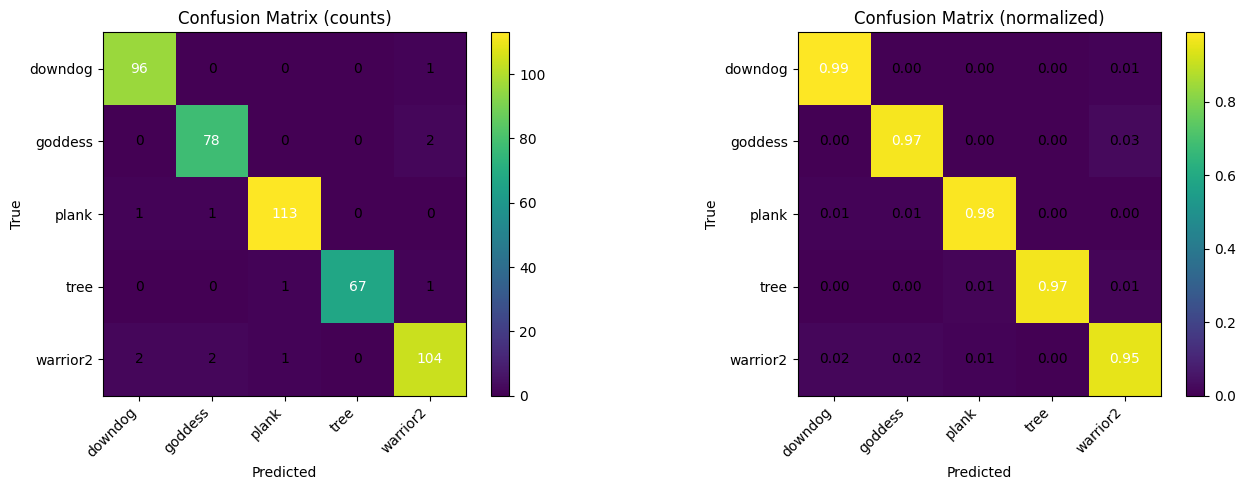

,precision,recall,f1-score,support
downdog,0.9697,0.9897,0.9796,97.0000
goddess,0.9630,0.9750,0.9689,80.0000
plank,0.9826,0.9826,0.9826,115.0000
tree,1.0000,0.9710,0.9853,69.0000
warrior2,0.9630,0.9541,0.9585,109.0000
accuracy,0.9745,0.9745,0.9745,0.9745
macro avg,0.9756,0.9745,0.9750,470.0000
weighted avg,0.9746,0.9745,0.9745,470.0000


Saved: classification_report_vgg16_mediapipe.csv


In [ ]:
import numpy as np, pandas as pd
from sklearn.metrics import classification_report, confusion_matrix
import matplotlib.pyplot as plt

eval_model = vgg_skel

y_true, y_pred = [], []
for xb, yb in skel_test_ds:
    p = eval_model.predict(xb, verbose=0)
    y_pred.append(np.argmax(p, axis=1))
    y_true.append(np.argmax(yb.numpy(), axis=1))
y_pred = np.concatenate(y_pred); y_true = np.concatenate(y_true)

cm  = confusion_matrix(y_true, y_pred, labels=range(skel_num_classes))
cmn = confusion_matrix(y_true, y_pred, labels=range(skel_num_classes), normalize='true')

fig, axes = plt.subplots(1,2, figsize=(14,5))
im0 = axes[0].imshow(cm);  axes[0].set_title("Confusion Matrix (counts)")
axes[0].set_xlabel("Predicted"); axes[0].set_ylabel("True")
axes[0].set_xticks(range(skel_num_classes)); axes[0].set_yticks(range(skel_num_classes))
axes[0].set_xticklabels(skel_class_names, rotation=45, ha='right'); axes[0].set_yticklabels(skel_class_names)
plt.colorbar(im0, ax=axes[0], fraction=0.046, pad=0.04)
for i in range(skel_num_classes):
    for j in range(skel_num_classes):
        axes[0].text(j, i, cm[i, j], ha='center', va='center',
                     color='white' if cm[i,j] > cm.max()/2 else 'black')

im1 = axes[1].imshow(cmn); axes[1].set_title("Confusion Matrix (normalized)")
axes[1].set_xlabel("Predicted"); axes[1].set_ylabel("True")
axes[1].set_xticks(range(skel_num_classes)); axes[1].set_yticks(range(skel_num_classes))
axes[1].set_xticklabels(skel_class_names, rotation=45, ha='right'); axes[1].set_yticklabels(skel_class_names)
plt.colorbar(im1, ax=axes[1], fraction=0.046, pad=0.04)
for i in range(skel_num_classes):
    for j in range(skel_num_classes):
        axes[1].text(j, i, f"{cmn[i, j]:.2f}", ha='center', va='center',
                     color='white' if cmn[i,j] > cmn.max()/2 else 'black')
plt.tight_layout(); plt.show()

rep = classification_report(y_true, y_pred, target_names=skel_class_names, output_dict=True, digits=4)
df_report = pd.DataFrame(rep).transpose()
display(df_report.style.format(precision=4))
df_report.to_csv("classification_report_vgg16_mediapipe.csv", index=True)
print("Saved: classification_report_vgg16_mediapipe.csv")


InceptionResNetV2

In [ ]:
##Importing Resnet and a little augmentation for the dataset

from tensorflow.keras.applications import InceptionResNetV2
from tensorflow.keras.applications.inception_resnet_v2 import preprocess_input
from tensorflow import keras
from tensorflow.keras import layers
import numpy as np, matplotlib.pyplot as plt
from sklearn.metrics import classification_report, confusion_matrix

# Keep flip OFF unless left/right doesn't change the label
USE_FLIP_IR = False
aug_ir = keras.Sequential(
    [layers.RandomRotation(0.07),
     layers.RandomZoom(0.07),
     layers.RandomContrast(0.1)] +
    ([layers.RandomFlip("horizontal")] if USE_FLIP_IR else []),
    name="aug_ir"
)

IR_TARGET_SIZE = (299, 299)  # default for InceptionResNetV2


In [ ]:
def build_irv2_classifier(input_shape, num_classes, dropout=0.3, train_base=False):
    """
    input_shape: shape coming from your dataset (e.g., 224x224x3). We internally resize to 299x299.
    """
    base = InceptionResNetV2(weights="imagenet", include_top=False, input_shape=IR_TARGET_SIZE + (3,))
    base.trainable = train_base  # freeze for head-training

    inputs = layers.Input(shape=input_shape)
    x = aug_ir(inputs)                                 # train-time augmentation
    x = layers.Resizing(*IR_TARGET_SIZE)(x)            # resize to 299x299
    x = layers.Lambda(lambda t: tf.cast(t, tf.float32))(x)
    x = layers.Lambda(preprocess_input, name="irv2_preprocess")(x)  # scales to [-1, 1]

    # Keep BN layers in inference mode during fine-tuning per Keras guide
    x = base(x, training=False)                        # important for models with BatchNorm
    x = layers.GlobalAveragePooling2D()(x)
    x = layers.Dropout(dropout)(x)
    outputs = layers.Dense(num_classes, activation="softmax")(x)
    model = keras.Model(inputs, outputs, name="IRV2_transfer")
    return model, base


In [ ]:
# Uses class_names/num_classes and train_ds/val_ds/test_ds from earlier sections
raw_input_shape = (224, 224, 3)  # your dataset loader size; model will resize to 299 inside

irv2_raw, irv2_raw_base = build_irv2_classifier(raw_input_shape, num_classes, dropout=0.35, train_base=False)
irv2_raw.compile(optimizer=keras.optimizers.Adam(1e-3),
                 loss=keras.losses.CategoricalCrossentropy(),
                 metrics=["accuracy"])
irv2_raw.summary()

EPOCHS_HEAD = 10
hist_ir_raw_head = irv2_raw.fit(
    train_ds, validation_data=val_ds, epochs=EPOCHS_HEAD,
    callbacks=[
        keras.callbacks.ModelCheckpoint("irv2_raw_head.keras", save_best_only=True, monitor="val_accuracy"),
        keras.callbacks.EarlyStopping(monitor="val_accuracy", patience=5, restore_best_weights=True)
    ],
    verbose=1
)


219055592/219055592 ━━━━━━━━━━━━━━━━━━━━ 6s 0us/step


Model: "IRV2_transfer"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ input_layer_4 (InputLayer)      │ (None, 224, 224, 3)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ aug_ir (Sequential)             │ (None, 224, 224, 3)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ resizing (Resizing)             │ (None, 299, 299, 3)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ lambda_1 (Lambda)               │ (None, 299, 299, 3)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ irv2_preprocess (Lambda)        │ (None, 299, 299, 3)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ inception_resnet_v2             │ (None, 8, 8, 1536)     │    54,336,736 │
│ (Functional)                    │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ global_average_pooling2d_1      │ (None, 1536)           │             0 │
│ (GlobalAveragePooling2D)        │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_1 (Dropout)             │ (None, 1536)           │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 5)              │         7,685 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 54,344,421 (207.31 MB)

 Trainable params: 7,685 (30.02 KB)

 Non-trainable params: 54,336,736 (207.28 MB)

Epoch 1/10
     28/Unknown 43s 372ms/step - accuracy: 0.2817 - loss: 1.6564

/usr/local/lib/python3.12/dist-packages/keras/src/trainers/epoch_iterator.py:160: UserWarning: Your input ran out of data; interrupting training. Make sure that your dataset or generator can generate at least `steps_per_epoch * epochs` batches. You may need to use the `.repeat()` function when building your dataset.
  self._interrupted_warning()


28/28 ━━━━━━━━━━━━━━━━━━━━ 59s 950ms/step - accuracy: 0.2826 - loss: 1.6537 - val_accuracy: 0.4676 - val_loss: 1.3133
Epoch 2/10
28/28 ━━━━━━━━━━━━━━━━━━━━ 17s 546ms/step - accuracy: 0.4433 - loss: 1.3563 - val_accuracy: 0.5648 - val_loss: 1.1493
Epoch 3/10
28/28 ━━━━━━━━━━━━━━━━━━━━ 20s 525ms/step - accuracy: 0.5393 - loss: 1.2118 - val_accuracy: 0.6389 - val_loss: 1.0519
Epoch 4/10
28/28 ━━━━━━━━━━━━━━━━━━━━ 15s 532ms/step - accuracy: 0.6190 - loss: 1.0801 - val_accuracy: 0.6528 - val_loss: 0.9561
Epoch 5/10
28/28 ━━━━━━━━━━━━━━━━━━━━ 22s 782ms/step - accuracy: 0.5887 - loss: 1.0742 - val_accuracy: 0.6991 - val_loss: 0.8893
Epoch 6/10
28/28 ━━━━━━━━━━━━━━━━━━━━ 31s 417ms/step - accuracy: 0.6262 - loss: 0.9922 - val_accuracy: 0.6713 - val_loss: 0.9202
Epoch 7/10
28/28 ━━━━━━━━━━━━━━━━━━━━ 12s 426ms/step - accuracy: 0.6683 - loss: 0.9288 - val_accuracy: 0.6806 - val_loss: 0.9115
Epoch 8/10
28/28 ━━━━━━━━━━━━━━━━━━━━ 12s 429ms/step - accuracy: 0.6625 - loss: 0.9271 - val_accuracy: 0.694

In [ ]:
# Unfreeze last ~100 layers for fine-tuning
for i, layer in enumerate(irv2_raw_base.layers):
    layer.trainable = (i >= len(irv2_raw_base.layers) - 100)

irv2_raw.compile(optimizer=keras.optimizers.Adam(1e-5),
                 loss=keras.losses.CategoricalCrossentropy(),
                 metrics=["accuracy"])

EPOCHS_FT = 15
hist_ir_raw_ft = irv2_raw.fit(
    train_ds, validation_data=val_ds, epochs=EPOCHS_FT,
    callbacks=[
        keras.callbacks.ModelCheckpoint("irv2_raw_finetuned.keras", save_best_only=True, monitor="val_accuracy"),
        keras.callbacks.EarlyStopping(monitor="val_accuracy", patience=6, restore_best_weights=True)
    ],
    verbose=1
)


Epoch 1/15
28/28 ━━━━━━━━━━━━━━━━━━━━ 55s 937ms/step - accuracy: 0.5575 - loss: 1.1230 - val_accuracy: 0.7361 - val_loss: 0.6875
Epoch 2/15
28/28 ━━━━━━━━━━━━━━━━━━━━ 32s 637ms/step - accuracy: 0.6861 - loss: 0.8700 - val_accuracy: 0.8009 - val_loss: 0.6180
Epoch 3/15
28/28 ━━━━━━━━━━━━━━━━━━━━ 20s 721ms/step - accuracy: 0.7690 - loss: 0.7569 - val_accuracy: 0.8056 - val_loss: 0.5735
Epoch 4/15
28/28 ━━━━━━━━━━━━━━━━━━━━ 19s 663ms/step - accuracy: 0.7513 - loss: 0.7101 - val_accuracy: 0.8241 - val_loss: 0.5351
Epoch 5/15
28/28 ━━━━━━━━━━━━━━━━━━━━ 20s 708ms/step - accuracy: 0.8130 - loss: 0.6296 - val_accuracy: 0.8611 - val_loss: 0.5028
Epoch 6/15
28/28 ━━━━━━━━━━━━━━━━━━━━ 22s 788ms/step - accuracy: 0.8320 - loss: 0.5275 - val_accuracy: 0.8657 - val_loss: 0.4744
Epoch 7/15
28/28 ━━━━━━━━━━━━━━━━━━━━ 22s 795ms/step - accuracy: 0.8577 - loss: 0.4989 - val_accuracy: 0.8750 - val_loss: 0.4486
Epoch 8/15
28/28 ━━━━━━━━━━━━━━━━━━━━ 34s 526ms/step - accuracy: 0.8821 - loss: 0.4383 - val_accu

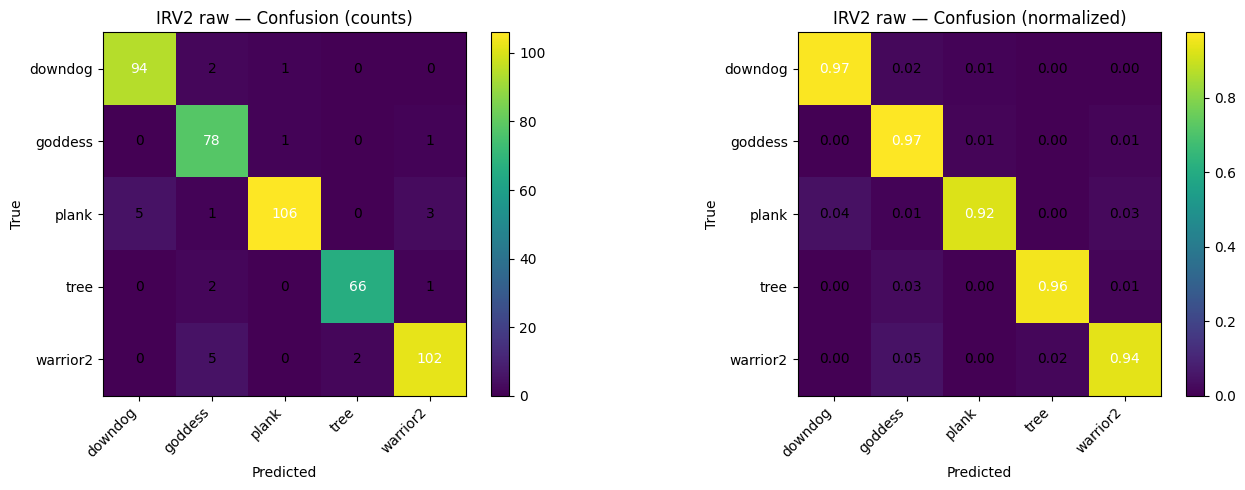

,precision,recall,f1-score,support
downdog,0.9495,0.9691,0.9592,97.0000
goddess,0.8864,0.9750,0.9286,80.0000
plank,0.9815,0.9217,0.9507,115.0000
tree,0.9706,0.9565,0.9635,69.0000
warrior2,0.9533,0.9358,0.9444,109.0000
accuracy,0.9489,0.9489,0.9489,0.9489
macro avg,0.9482,0.9516,0.9493,470.0000
weighted avg,0.9505,0.9489,0.9491,470.0000


Saved: classification_report_irv2_raw.csv


In [ ]:
# Reuse your earlier plotting helpers or do a quick evaluation here:
import pandas as pd

y_true, y_pred = [], []
for xb, yb in test_ds:
    p = irv2_raw.predict(xb, verbose=0)
    y_pred.append(np.argmax(p, axis=1))
    y_true.append(np.argmax(yb.numpy(), axis=1))
y_pred = np.concatenate(y_pred); y_true = np.concatenate(y_true)

cm  = confusion_matrix(y_true, y_pred, labels=range(num_classes))
cmn = confusion_matrix(y_true, y_pred, labels=range(num_classes), normalize='true')

fig, axes = plt.subplots(1,2, figsize=(14,5))
im0 = axes[0].imshow(cm);  axes[0].set_title("IRV2 raw — Confusion (counts)")
axes[0].set_xlabel("Predicted"); axes[0].set_ylabel("True")
axes[0].set_xticks(range(num_classes)); axes[0].set_yticks(range(num_classes))
axes[0].set_xticklabels(class_names, rotation=45, ha='right'); axes[0].set_yticklabels(class_names)
plt.colorbar(im0, ax=axes[0], fraction=0.046, pad=0.04)
for i in range(num_classes):
    for j in range(num_classes):
        axes[0].text(j, i, cm[i, j], ha='center', va='center',
                     color='white' if cm[i,j] > cm.max()/2 else 'black')

im1 = axes[1].imshow(cmn); axes[1].set_title("IRV2 raw — Confusion (normalized)")
axes[1].set_xlabel("Predicted"); axes[1].set_ylabel("True")
axes[1].set_xticks(range(num_classes)); axes[1].set_yticks(range(num_classes))
axes[1].set_xticklabels(class_names, rotation=45, ha='right'); axes[1].set_yticklabels(class_names)
plt.colorbar(im1, ax=axes[1], fraction=0.046, pad=0.04)
for i in range(num_classes):
    for j in range(num_classes):
        axes[1].text(j, i, f"{cmn[i, j]:.2f}", ha='center', va='center',
                     color='white' if cmn[i,j] > cmn.max()/2 else 'black')
plt.tight_layout(); plt.show()

rep = classification_report(y_true, y_pred, target_names=class_names, output_dict=True, digits=4)
df_rep = pd.DataFrame(rep).transpose()
display(df_rep.style.format(precision=4))
df_rep.to_csv("classification_report_irv2_raw.csv")
print("Saved: classification_report_irv2_raw.csv")


INCEPTION RESNET MODEL WITH MEDIA PIPE

In [ ]:
skel_input_shape = (224, 224, 3)  # your skeleton loader size; we resize to 299 inside

irv2_skel, irv2_skel_base = build_irv2_classifier(skel_input_shape, skel_num_classes, dropout=0.35, train_base=False)
irv2_skel.compile(optimizer=keras.optimizers.Adam(1e-3),
                  loss=keras.losses.CategoricalCrossentropy(),
                  metrics=["accuracy"])
irv2_skel.summary()

EPOCHS_HEAD = 10
hist_ir_skel_head = irv2_skel.fit(
    skel_train_ds, validation_data=skel_val_ds, epochs=EPOCHS_HEAD,
    callbacks=[
        keras.callbacks.ModelCheckpoint("irv2_skel_head.keras", save_best_only=True, monitor="val_accuracy"),
        keras.callbacks.EarlyStopping(monitor="val_accuracy", patience=5, restore_best_weights=True)
    ],
    verbose=1
)


Model: "IRV2_transfer"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ input_layer_7 (InputLayer)      │ (None, 224, 224, 3)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ aug_ir (Sequential)             │ (None, 224, 224, 3)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ resizing_1 (Resizing)           │ (None, 299, 299, 3)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ lambda_2 (Lambda)               │ (None, 299, 299, 3)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ irv2_preprocess (Lambda)        │ (None, 299, 299, 3)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ inception_resnet_v2             │ (None, 8, 8, 1536)     │    54,336,736 │
│ (Functional)                    │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ global_average_pooling2d_2      │ (None, 1536)           │             0 │
│ (GlobalAveragePooling2D)        │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_2 (Dropout)             │ (None, 1536)           │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_2 (Dense)                 │ (None, 5)              │         7,685 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 54,344,421 (207.31 MB)

 Trainable params: 7,685 (30.02 KB)

 Non-trainable params: 54,336,736 (207.28 MB)

Epoch 1/10
     28/Unknown 31s 334ms/step - accuracy: 0.2889 - loss: 1.5987

/usr/local/lib/python3.12/dist-packages/keras/src/trainers/epoch_iterator.py:160: UserWarning: Your input ran out of data; interrupting training. Make sure that your dataset or generator can generate at least `steps_per_epoch * epochs` batches. You may need to use the `.repeat()` function when building your dataset.
  self._interrupted_warning()


28/28 ━━━━━━━━━━━━━━━━━━━━ 43s 809ms/step - accuracy: 0.2913 - loss: 1.5950 - val_accuracy: 0.5417 - val_loss: 1.1525
Epoch 2/10
28/28 ━━━━━━━━━━━━━━━━━━━━ 20s 728ms/step - accuracy: 0.4861 - loss: 1.2356 - val_accuracy: 0.6574 - val_loss: 0.9317
Epoch 3/10
28/28 ━━━━━━━━━━━━━━━━━━━━ 20s 756ms/step - accuracy: 0.6628 - loss: 0.9532 - val_accuracy: 0.7037 - val_loss: 0.8004
Epoch 4/10
28/28 ━━━━━━━━━━━━━━━━━━━━ 41s 732ms/step - accuracy: 0.7284 - loss: 0.8179 - val_accuracy: 0.7546 - val_loss: 0.7269
Epoch 5/10
28/28 ━━━━━━━━━━━━━━━━━━━━ 20s 740ms/step - accuracy: 0.7281 - loss: 0.7808 - val_accuracy: 0.8056 - val_loss: 0.6628
Epoch 6/10
28/28 ━━━━━━━━━━━━━━━━━━━━ 18s 638ms/step - accuracy: 0.7557 - loss: 0.7167 - val_accuracy: 0.7500 - val_loss: 0.6956
Epoch 7/10
28/28 ━━━━━━━━━━━━━━━━━━━━ 12s 425ms/step - accuracy: 0.7769 - loss: 0.6700 - val_accuracy: 0.8056 - val_loss: 0.6407
Epoch 8/10
28/28 ━━━━━━━━━━━━━━━━━━━━ 12s 424ms/step - accuracy: 0.8040 - loss: 0.6317 - val_accuracy: 0.754

In [ ]:
for i, layer in enumerate(irv2_skel_base.layers):
    layer.trainable = (i >= len(irv2_skel_base.layers) - 100)

irv2_skel.compile(optimizer=keras.optimizers.Adam(1e-5),
                  loss=keras.losses.CategoricalCrossentropy(),
                  metrics=["accuracy"])

EPOCHS_FT = 15
hist_ir_skel_ft = irv2_skel.fit(
    skel_train_ds, validation_data=skel_val_ds, epochs=EPOCHS_FT,
    callbacks=[
        keras.callbacks.ModelCheckpoint("irv2_skel_finetuned.keras", save_best_only=True, monitor="val_accuracy"),
        keras.callbacks.EarlyStopping(monitor="val_accuracy", patience=6, restore_best_weights=True)
    ],
    verbose=1
)


Epoch 1/15
28/28 ━━━━━━━━━━━━━━━━━━━━ 57s 1s/step - accuracy: 0.4915 - loss: 1.2234 - val_accuracy: 0.8333 - val_loss: 0.5110
Epoch 2/15
28/28 ━━━━━━━━━━━━━━━━━━━━ 27s 505ms/step - accuracy: 0.7242 - loss: 0.7026 - val_accuracy: 0.8056 - val_loss: 0.5099
Epoch 3/15
28/28 ━━━━━━━━━━━━━━━━━━━━ 15s 525ms/step - accuracy: 0.8268 - loss: 0.5606 - val_accuracy: 0.8148 - val_loss: 0.4929
Epoch 4/15
28/28 ━━━━━━━━━━━━━━━━━━━━ 14s 486ms/step - accuracy: 0.8420 - loss: 0.4943 - val_accuracy: 0.8333 - val_loss: 0.4661
Epoch 5/15
28/28 ━━━━━━━━━━━━━━━━━━━━ 14s 485ms/step - accuracy: 0.8585 - loss: 0.4423 - val_accuracy: 0.8287 - val_loss: 0.4477
Epoch 6/15
28/28 ━━━━━━━━━━━━━━━━━━━━ 14s 486ms/step - accuracy: 0.8635 - loss: 0.4206 - val_accuracy: 0.8333 - val_loss: 0.4319
Epoch 7/15
28/28 ━━━━━━━━━━━━━━━━━━━━ 40s 485ms/step - accuracy: 0.8548 - loss: 0.4517 - val_accuracy: 0.8287 - val_loss: 0.4243


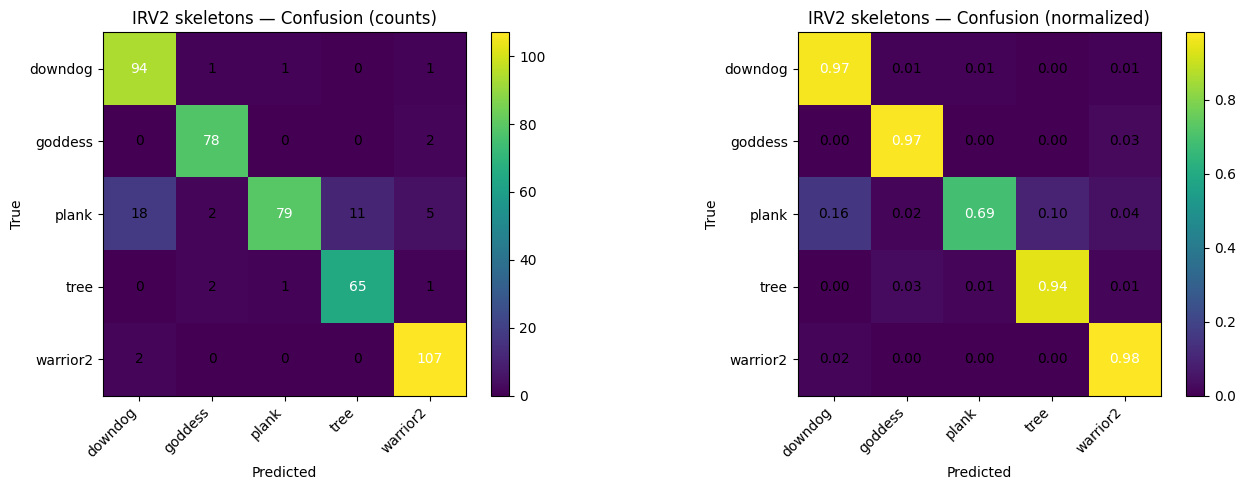

,precision,recall,f1-score,support
downdog,0.8246,0.9691,0.8910,97.0000
goddess,0.9398,0.9750,0.9571,80.0000
plank,0.9753,0.6870,0.8061,115.0000
tree,0.8553,0.9420,0.8966,69.0000
warrior2,0.9224,0.9817,0.9511,109.0000
accuracy,0.9000,0.9000,0.9000,0.9000
macro avg,0.9035,0.9109,0.9004,470.0000
weighted avg,0.9083,0.9000,0.8962,470.0000


Saved: classification_report_irv2_skeletons.csv


In [ ]:
import pandas as pd

y_true, y_pred = [], []
for xb, yb in skel_test_ds:
    p = irv2_skel.predict(xb, verbose=0)
    y_pred.append(np.argmax(p, axis=1))
    y_true.append(np.argmax(yb.numpy(), axis=1))
y_pred = np.concatenate(y_pred); y_true = np.concatenate(y_true)

cm  = confusion_matrix(y_true, y_pred, labels=range(skel_num_classes))
cmn = confusion_matrix(y_true, y_pred, labels=range(skel_num_classes), normalize='true')

fig, axes = plt.subplots(1,2, figsize=(14,5))
im0 = axes[0].imshow(cm);  axes[0].set_title("IRV2 skeletons — Confusion (counts)")
axes[0].set_xlabel("Predicted"); axes[0].set_ylabel("True")
axes[0].set_xticks(range(skel_num_classes)); axes[0].set_yticks(range(skel_num_classes))
axes[0].set_xticklabels(skel_class_names, rotation=45, ha='right'); axes[0].set_yticklabels(skel_class_names)
plt.colorbar(im0, ax=axes[0], fraction=0.046, pad=0.04)
for i in range(skel_num_classes):
    for j in range(skel_num_classes):
        axes[0].text(j, i, cm[i, j], ha='center', va='center',
                     color='white' if cm[i,j] > cm.max()/2 else 'black')

im1 = axes[1].imshow(cmn); axes[1].set_title("IRV2 skeletons — Confusion (normalized)")
axes[1].set_xlabel("Predicted"); axes[1].set_ylabel("True")
axes[1].set_xticks(range(skel_num_classes)); axes[1].set_yticks(range(skel_num_classes))
axes[1].set_xticklabels(skel_class_names, rotation=45, ha='right'); axes[1].set_yticklabels(skel_class_names)
plt.colorbar(im1, ax=axes[1], fraction=0.046, pad=0.04)
for i in range(skel_num_classes):
    for j in range(skel_num_classes):
        axes[1].text(j, i, f"{cmn[i, j]:.2f}", ha='center', va='center',
                     color='white' if cmn[i,j] > cmn.max()/2 else 'black')
plt.tight_layout(); plt.show()

rep = classification_report(y_true, y_pred, target_names=skel_class_names, output_dict=True, digits=4)
df_rep = pd.DataFrame(rep).transpose()
display(df_rep.style.format(precision=4))
df_rep.to_csv("classification_report_irv2_skeletons.csv")
print("Saved: classification_report_irv2_skeletons.csv")


ANN

In [ ]:

import os, math, itertools, random, pathlib
from pathlib import Path

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers

# Repro
SEED = 1337
tf.keras.utils.set_random_seed(SEED)

# Dataset layout:
# /content/DATASET/
#   TRAIN/<class>/*.jpg
#   TEST/<class>/*.jpg
DATA_ROOT = "/content/drive/MyDrive/DLRV/DATASET/DATASET"   # <--- change if needed
TRAIN_DIR = os.path.join(DATA_ROOT, "TRAIN")
TEST_DIR  = os.path.join(DATA_ROOT, "TEST")

# Image & batch
IMG_SIZE  = (224, 224)
BATCH     = 32
AUTOTUNE  = tf.data.AUTOTUNE


In [ ]:

train_ds = tf.keras.utils.image_dataset_from_directory(
    TRAIN_DIR, image_size=IMG_SIZE, batch_size=BATCH,
    label_mode="categorical", shuffle=True, validation_split=0.2,
    subset="training", seed=SEED, interpolation="bilinear"
)
val_ds = tf.keras.utils.image_dataset_from_directory(
    TRAIN_DIR, image_size=IMG_SIZE, batch_size=BATCH,
    label_mode="categorical", shuffle=False, validation_split=0.2,
    subset="validation", seed=SEED, interpolation="bilinear"
)
test_ds = tf.keras.utils.image_dataset_from_directory(
    TEST_DIR, image_size=IMG_SIZE, batch_size=BATCH,
    label_mode="categorical", shuffle=False, interpolation="bilinear"
)

class_names = train_ds.class_names
num_classes = len(class_names)
class_names, num_classes

# Performance: cache & prefetch
def speed(ds, cache=True):
    if cache: ds = ds.cache()
    return ds.prefetch(AUTOTUNE)

train_ds = speed(train_ds, cache=True)
val_ds   = speed(val_ds,   cache=True)
test_ds  = speed(test_ds,  cache=False)


Found 1081 files belonging to 5 classes.
Using 865 files for training.
Found 1081 files belonging to 5 classes.
Using 216 files for validation.
Found 470 files belonging to 5 classes.


In [ ]:
# ===== Cell 3: helpers =====
from sklearn.metrics import classification_report, confusion_matrix

def plot_history(history, title_prefix=""):
    h = history.history
    if "accuracy" in h:
        plt.figure(figsize=(7,4))
        plt.plot(h["accuracy"], label="train acc")
        if "val_accuracy" in h: plt.plot(h["val_accuracy"], label="val acc")
        plt.title(f"{title_prefix} Accuracy"); plt.xlabel("epoch"); plt.ylabel("accuracy"); plt.legend(); plt.tight_layout(); plt.show()
    if "loss" in h:
        plt.figure(figsize=(7,4))
        plt.plot(h["loss"], label="train loss")
        if "val_loss" in h: plt.plot(h["val_loss"], label="val loss")
        plt.title(f"{title_prefix} Loss"); plt.xlabel("epoch"); plt.ylabel("loss"); plt.legend(); plt.tight_layout(); plt.show()

def evaluate_cm_report(model, dataset, class_names, out_dir, csv_name="classification_report.csv",
                       normalize='true', zero_division=0):
    out = Path(out_dir); out.mkdir(parents=True, exist_ok=True)
    # y_true (handles one-hot)
    y_true_batches = []
    for _, yb in dataset:
        yb = yb.numpy()
        y_true_batches.append(np.argmax(yb, axis=1) if yb.ndim == 2 else yb.astype(int))
    y_true = np.concatenate(y_true_batches, axis=0)
    # y_pred
    y_prob = model.predict(dataset, verbose=0)
    y_pred = np.argmax(y_prob, axis=1)

    labels = list(range(len(class_names)))
    cm  = confusion_matrix(y_true, y_pred, labels=labels)
    cmn = confusion_matrix(y_true, y_pred, labels=labels, normalize=normalize)

    rep = classification_report(y_true, y_pred, target_names=class_names,
                                output_dict=True, zero_division=zero_division)
    df_rep = pd.DataFrame(rep).transpose()
    # Save CSVs
    df_rep.to_csv(out/csv_name, float_format="%.4f")
    pd.DataFrame(cm,  index=class_names, columns=class_names).to_csv(out/"confusion_counts.csv")
    pd.DataFrame(cmn, index=class_names, columns=class_names).to_csv(out/"confusion_normalized.csv", float_format="%.4f")
    print("Saved:", out/csv_name, "|", out/"confusion_counts.csv", "|", out/"confusion_normalized.csv")

    # Plots
    fig, axes = plt.subplots(1,2, figsize=(14,5))
    im0 = axes[0].imshow(cm);  axes[0].set_title("Confusion (counts)")
    axes[0].set_xlabel("Predicted"); axes[0].set_ylabel("True")
    axes[0].set_xticks(range(len(class_names))); axes[0].set_yticks(range(len(class_names)))
    axes[0].set_xticklabels(class_names, rotation=45, ha='right'); axes[0].set_yticklabels(class_names)
    for i in range(cm.shape[0]):
        for j in range(cm.shape[1]):
            axes[0].text(j,i,int(cm[i,j]),ha='center',va='center',
                         color='white' if cm[i,j] > cm.max()/2 else 'black')
    plt.colorbar(im0, ax=axes[0], fraction=0.046, pad=0.04)

    im1 = axes[1].imshow(cmn); axes[1].set_title(f"Confusion (normalized={normalize})")
    axes[1].set_xlabel("Predicted"); axes[1].set_ylabel("True")
    axes[1].set_xticks(range(len(class_names))); axes[1].set_yticks(range(len(class_names)))
    axes[1].set_xticklabels(class_names, rotation=45, ha='right'); axes[1].set_yticklabels(class_names)
    for i in range(cmn.shape[0]):
        for j in range(cmn.shape[1]):
            axes[1].text(j,i,f"{cmn[i,j]:.2f}",ha='center',va='center',
                         color='white' if cmn[i,j] > cmn.max()/2 else 'black')
    plt.colorbar(im1, ax=axes[1], fraction=0.046, pad=0.04)
    plt.tight_layout(); plt.show()

    return df_rep, cm, cmn

# Common callbacks
def common_callbacks(name, monitor="val_accuracy", patience=6):
    return [
        keras.callbacks.ModelCheckpoint(f"{name}.keras", save_best_only=True, monitor=monitor),
        keras.callbacks.EarlyStopping(monitor=monitor, patience=patience, restore_best_weights=True),
        keras.callbacks.ReduceLROnPlateau(monitor=monitor, factor=0.5, patience=max(2, patience//2), verbose=1, min_lr=1e-7)
    ]


In [ ]:

data_augment = keras.Sequential([
    layers.RandomFlip("horizontal"),
    layers.RandomRotation(0.08),
    layers.RandomZoom(0.1),
], name="augment")


/usr/local/lib/python3.12/dist-packages/keras/src/layers/preprocessing/tf_data_layer.py:19: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


Model: "ANN_Simple"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ rescaling (Rescaling)           │ (None, 224, 224, 3)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten (Flatten)               │ (None, 150528)         │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 256)            │    38,535,424 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout (Dropout)               │ (None, 256)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 128)            │        32,896 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_1 (Dropout)             │ (None, 128)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_2 (Dense)                 │ (None, 5)              │           645 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 38,568,965 (147.13 MB)

 Trainable params: 38,568,965 (147.13 MB)

 Non-trainable params: 0 (0.00 B)

Epoch 1/20
28/28 ━━━━━━━━━━━━━━━━━━━━ 22s 648ms/step - accuracy: 0.2125 - loss: 18.8004 - val_accuracy: 0.0000e+00 - val_loss: 7.5709 - learning_rate: 3.0000e-04
Epoch 2/20
28/28 ━━━━━━━━━━━━━━━━━━━━ 21s 13ms/step - accuracy: 0.2005 - loss: 5.5640 - val_accuracy: 0.0000e+00 - val_loss: 1.6201 - learning_rate: 3.0000e-04
Epoch 3/20
28/28 ━━━━━━━━━━━━━━━━━━━━ 5s 193ms/step - accuracy: 0.1931 - loss: 1.6145 - val_accuracy: 1.0000 - val_loss: 1.6023 - learning_rate: 3.0000e-04
Epoch 4/20
28/28 ━━━━━━━━━━━━━━━━━━━━ 0s 13ms/step - accuracy: 0.2451 - loss: 1.6089 - val_accuracy: 1.0000 - val_loss: 1.5981 - learning_rate: 3.0000e-04
Epoch 5/20
28/28 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step - accuracy: 0.2543 - loss: 1.6079 - val_accuracy: 1.0000 - val_loss: 1.5940 - learning_rate: 3.0000e-04
Epoch 6/20
24/28 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step - accuracy: 0.2581 - loss: 1.6070
Epoch 6: ReduceLROnPlateau reducing learning rate to 0.0001500000071246177.
28/28 ━━━━━━━━━━━━━━━━━━━━ 1s 11ms/step - accuracy:

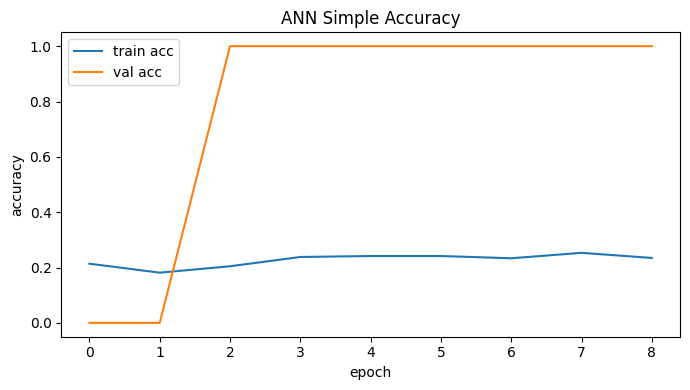

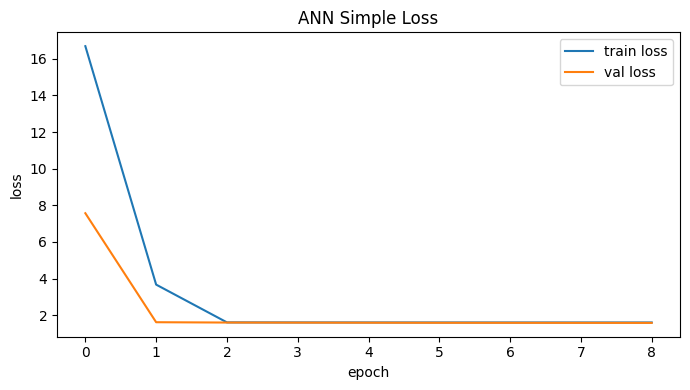

Saved: metrics_ann_simple/classification_report_ann_simple.csv | metrics_ann_simple/confusion_counts.csv | metrics_ann_simple/confusion_normalized.csv


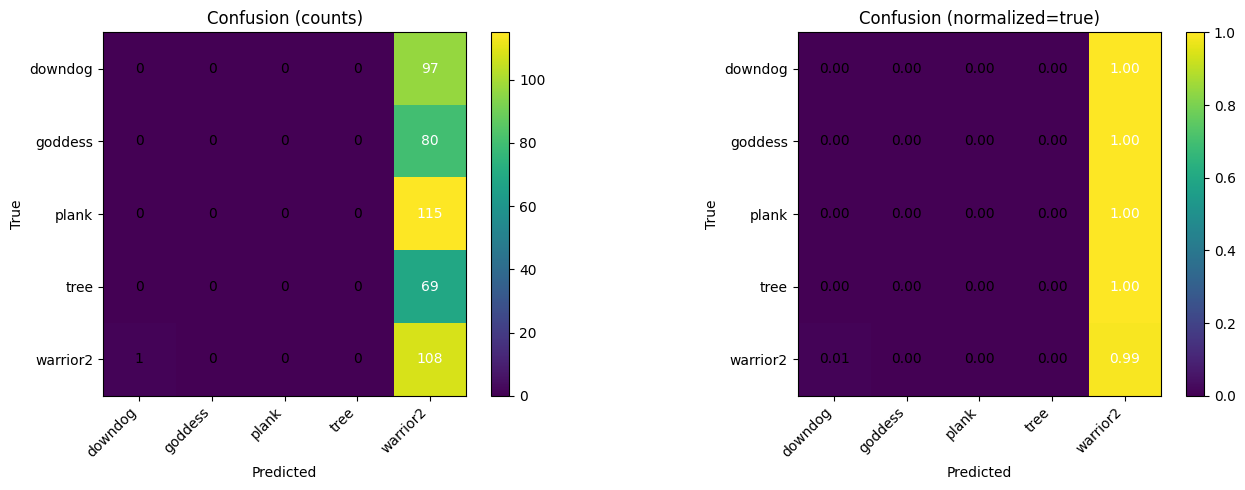

(              precision    recall  f1-score     support
 downdog        0.000000  0.000000  0.000000   97.000000
 goddess        0.000000  0.000000  0.000000   80.000000
 plank          0.000000  0.000000  0.000000  115.000000
 tree           0.000000  0.000000  0.000000   69.000000
 warrior2       0.230277  0.990826  0.373702  109.000000
 accuracy       0.229787  0.229787  0.229787    0.229787
 macro avg      0.046055  0.198165  0.074740  470.000000
 weighted avg   0.053405  0.229787  0.086667  470.000000,
 array([[  0,   0,   0,   0,  97],
        [  0,   0,   0,   0,  80],
        [  0,   0,   0,   0, 115],
        [  0,   0,   0,   0,  69],
        [  1,   0,   0,   0, 108]]),
 array([[0.        , 0.        , 0.        , 0.        , 1.        ],
        [0.        , 0.        , 0.        , 0.        , 1.        ],
        [0.        , 0.        , 0.        , 0.        , 1.        ],
        [0.        , 0.        , 0.        , 0.        , 1.        ],
        [0.00917431, 0.      

In [ ]:
# ===== Cell 5: ANN simple =====
def build_ann_simple(input_shape, num_classes):
    return keras.Sequential([
        layers.Rescaling(1./255, input_shape=input_shape),
        layers.Flatten(),
        layers.Dense(256, activation="relu"),
        layers.Dropout(0.3),
        layers.Dense(128, activation="relu"),
        layers.Dropout(0.2),
        layers.Dense(num_classes, activation="softmax"),
    ], name="ANN_Simple")

ann_simple = build_ann_simple(IMG_SIZE + (3,), num_classes)
ann_simple.compile(optimizer=keras.optimizers.Adam(3e-4),
                   loss="categorical_crossentropy", metrics=["accuracy"])
ann_simple.summary()

EPOCHS_ANN = 20
hist_ann = ann_simple.fit(
    train_ds, validation_data=val_ds, epochs=EPOCHS_ANN,
    callbacks=common_callbacks("ann_simple"), verbose=1
)

plot_history(hist_ann, "ANN Simple")
evaluate_cm_report(ann_simple, test_ds, class_names, out_dir="metrics_ann_simple",
                   csv_name="classification_report_ann_simple.csv")


ANN with Pose Skeletons

In [ ]:

!pip -q install mediapipe opencv-python-headless

import os, sys, math, time, glob, shutil, pathlib
from pathlib import Path
import numpy as np
import cv2
import mediapipe as mp
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers
import matplotlib.pyplot as plt


   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 50.0/50.0 MB 16.6 MB/s eta 0:00:00


In [ ]:
# Cell 2 — paths & config
SEED = 1337
tf.keras.utils.set_random_seed(SEED)

# Your original dataset with class subfolders
DATA_ROOT = "/content/drive/MyDrive/DLRV/DATASET/DATASET"   # <-- change if needed
TRAIN_DIR = os.path.join(DATA_ROOT, "TRAIN")
TEST_DIR  = os.path.join(DATA_ROOT, "TEST")

# Where to write skeletonized images
SKEL_ROOT  = "/content/drive/MyDrive/DLRV/DATASET/SKELETONS"
SKEL_TRAIN = os.path.join(SKEL_ROOT, "TRAIN")
SKEL_TEST  = os.path.join(SKEL_ROOT, "TEST")

# Image/dataloader settings
IMG_SIZE = (224, 224)
BATCH    = 32
AUTOTUNE = tf.data.AUTOTUNE

IMG_EXTS = {".jpg", ".jpeg", ".png", ".bmp"}
Path(SKEL_TRAIN).mkdir(parents=True, exist_ok=True)
Path(SKEL_TEST).mkdir(parents=True, exist_ok=True)


In [ ]:
# Cell 3 — skeletonization helpers
mp_pose = mp.solutions.pose
mp_drawing = mp.solutions.drawing_utils
mp_styles = mp.solutions.drawing_styles

def skeletonize_image_bgr(img_bgr, landmark_style=None, connection_style=None, thickness=3):
    """Returns a new RGB image (uint8) with the pose skeleton drawn on a black canvas.
       If no person is detected, returns None."""
    with mp_pose.Pose(static_image_mode=True, model_complexity=1, enable_segmentation=False) as pose:
        img_rgb = cv2.cvtColor(img_bgr, cv2.COLOR_BGR2RGB)
        res = pose.process(img_rgb)
        if not res.pose_landmarks:
            return None
        h, w = img_bgr.shape[:2]
        canvas = np.zeros((h, w, 3), dtype=np.uint8)

        # Drawing specs (thicker/larger for visibility)
        if landmark_style is None:
            landmark_style = mp_drawing.DrawingSpec(thickness=thickness, circle_radius=thickness+1)
        if connection_style is None:
            connection_style = mp_drawing.DrawingSpec(thickness=thickness, circle_radius=1)

        mp_drawing.draw_landmarks(
            canvas,
            res.pose_landmarks,
            mp_pose.POSE_CONNECTIONS,
            landmark_drawing_spec=landmark_style,
            connection_drawing_spec=connection_style
        )
        return canvas  # RGB (uint8)

def skeletonize_folder(src_root, dst_root):
    """Walks class subfolders in src_root, writes skeleton PNGs to dst_root mirroring structure.
       Returns (classes, n_written, n_skipped)."""
    classes = sorted([d.name for d in Path(src_root).iterdir() if d.is_dir()])
    n_written, n_skipped = 0, 0
    for cls in classes:
        in_dir  = Path(src_root) / cls
        out_dir = Path(dst_root) / cls
        out_dir.mkdir(parents=True, exist_ok=True)
        for p in in_dir.rglob("*"):
            if p.suffix.lower() in IMG_EXTS:
                try:
                    img = cv2.imread(str(p))
                    if img is None:
                        n_skipped += 1
                        continue
                    skel = skeletonize_image_bgr(img, thickness=3)
                    if skel is None:
                        n_skipped += 1
                        continue
                    # Save as PNG; keep original stem
                    out_path = out_dir / (p.stem + ".png")
                    cv2.imwrite(str(out_path), cv2.cvtColor(skel, cv2.COLOR_RGB2BGR))
                    n_written += 1
                except Exception:
                    n_skipped += 1
    return classes, n_written, n_skipped


In [ ]:
def dir_has_images(d):
    return any((Path(d)/c).glob("*.*") for c in os.listdir(d)) if Path(d).exists() else False

need_train = not Path(SKEL_TRAIN).exists() or not dir_has_images(SKEL_TRAIN)
need_test  = not Path(SKEL_TEST).exists()  or not dir_has_images(SKEL_TEST)

if need_train:
    skel_classes_train, n_trn_written, n_trn_skipped = skeletonize_folder(TRAIN_DIR, SKEL_TRAIN)
else:
    skel_classes_train = sorted([d.name for d in Path(SKEL_TRAIN).iterdir() if d.is_dir()])
    n_trn_written = n_trn_skipped = -1

if need_test:
    skel_classes_test, n_tst_written, n_tst_skipped = skeletonize_folder(TEST_DIR, SKEL_TEST)
else:
    skel_classes_test = sorted([d.name for d in Path(SKEL_TEST).iterdir() if d.is_dir()])
    n_tst_written = n_tst_skipped = -1

assert skel_classes_train == skel_classes_test, "Train/Test class folders differ."
skel_class_names = skel_classes_train
skel_num_classes = len(skel_class_names)

print("Classes:", skel_class_names)
print("TRAIN written/skipped:", n_trn_written, n_trn_skipped, "->", SKEL_TRAIN)
print("TEST  written/skipped:", n_tst_written, n_tst_skipped, "->", SKEL_TEST)


Classes: ['downdog', 'goddess', 'plank', 'tree', 'warrior2']
TRAIN written/skipped: 1042 39 -> /content/drive/MyDrive/DLRV/DATASET/SKELETONS/TRAIN
TEST  written/skipped: 465 5 -> /content/drive/MyDrive/DLRV/DATASET/SKELETONS/TEST


In [ ]:
skel_train_ds = tf.keras.utils.image_dataset_from_directory(
    SKEL_TRAIN, image_size=IMG_SIZE, batch_size=BATCH,
    label_mode="categorical", shuffle=True, validation_split=0.2,
    subset="training", seed=SEED
)
skel_val_ds = tf.keras.utils.image_dataset_from_directory(
    SKEL_TRAIN, image_size=IMG_SIZE, batch_size=BATCH,
    label_mode="categorical", shuffle=False, validation_split=0.2,
    subset="validation", seed=SEED
)
skel_test_ds = tf.keras.utils.image_dataset_from_directory(
    SKEL_TEST, image_size=IMG_SIZE, batch_size=BATCH,
    label_mode="categorical", shuffle=False
)

# performance
def speed(ds, cache=True):
    if cache: ds = ds.cache()
    return ds.prefetch(AUTOTUNE)

skel_train_ds = speed(skel_train_ds, cache=True)
skel_val_ds   = speed(skel_val_ds,   cache=True)
skel_test_ds  = speed(skel_test_ds,  cache=False)


Found 1042 files belonging to 5 classes.
Using 834 files for training.
Found 1042 files belonging to 5 classes.
Using 208 files for validation.
Found 465 files belonging to 5 classes.


In [ ]:
# Cell 6 — helpers (plot_history + evaluate_cm_report)
from sklearn.metrics import classification_report, confusion_matrix
import pandas as pd

def plot_history(history, title_prefix=""):
    h = history.history
    if "accuracy" in h:
        plt.figure(figsize=(7,4))
        plt.plot(h["accuracy"], label="train acc")
        if "val_accuracy" in h: plt.plot(h["val_accuracy"], label="val acc")
        plt.title(f"{title_prefix} Accuracy"); plt.xlabel("epoch"); plt.ylabel("accuracy"); plt.legend(); plt.tight_layout(); plt.show()
    if "loss" in h:
        plt.figure(figsize=(7,4))
        plt.plot(h["loss"], label="train loss")
        if "val_loss" in h: plt.plot(h["val_loss"], label="val loss")
        plt.title(f"{title_prefix} Loss"); plt.xlabel("epoch"); plt.ylabel("loss"); plt.legend(); plt.tight_layout(); plt.show()

def evaluate_cm_report(model, dataset, class_names, out_dir, csv_name="classification_report.csv",
                       normalize='true', zero_division=0):
    out = Path(out_dir); out.mkdir(parents=True, exist_ok=True)

    # y_true (supports one-hot or int labels)
    y_true_batches = []
    for _, yb in dataset:
        yb = yb.numpy()
        y_true_batches.append(np.argmax(yb, axis=1) if yb.ndim == 2 else yb.astype(int))
    y_true = np.concatenate(y_true_batches, axis=0)

    # y_pred
    y_prob = model.predict(dataset, verbose=0)
    y_pred = np.argmax(y_prob, axis=1)

    labels = list(range(len(class_names)))
    cm  = confusion_matrix(y_true, y_pred, labels=labels)
    cmn = confusion_matrix(y_true, y_pred, labels=labels, normalize=normalize)

    rep = classification_report(y_true, y_pred, target_names=class_names,
                                output_dict=True, zero_division=zero_division)
    df_rep = pd.DataFrame(rep).transpose()

    # save CSVs
    df_rep.to_csv(out/csv_name, float_format="%.4f")
    pd.DataFrame(cm,  index=class_names, columns=class_names).to_csv(out/"confusion_counts.csv")
    pd.DataFrame(cmn, index=class_names, columns=class_names).to_csv(out/"confusion_normalized.csv", float_format="%.4f")
    print("Saved:", out/csv_name, "|", out/"confusion_counts.csv", "|", out/"confusion_normalized.csv")

    # quick heatmaps
    fig, axes = plt.subplots(1,2, figsize=(14,5))
    im0 = axes[0].imshow(cm);  axes[0].set_title("Confusion (counts)")
    axes[0].set_xlabel("Predicted"); axes[0].set_ylabel("True")
    axes[0].set_xticks(range(len(class_names))); axes[0].set_yticks(range(len(class_names)))
    axes[0].set_xticklabels(class_names, rotation=45, ha='right'); axes[0].set_yticklabels(class_names)
    for i in range(cm.shape[0]):
        for j in range(cm.shape[1]):
            axes[0].text(j,i,int(cm[i,j]),ha='center',va='center',
                         color='white' if cm[i,j] > cm.max()/2 else 'black')
    plt.colorbar(im0, ax=axes[0], fraction=0.046, pad=0.04)

    im1 = axes[1].imshow(cmn); axes[1].set_title(f"Confusion (normalized={normalize})")
    axes[1].set_xlabel("Predicted"); axes[1].set_ylabel("True")
    axes[1].set_xticks(range(len(class_names))); axes[1].set_yticks(range(len(class_names)))
    axes[1].set_xticklabels(class_names, rotation=45, ha='right'); axes[1].set_yticklabels(class_names)
    for i in range(cmn.shape[0]):
        for j in range(cmn.shape[1]):
            axes[1].text(j,i,f"{cmn[i,j]:.2f}",ha='center',va='center',
                         color='white' if cmn[i,j] > cmn.max()/2 else 'black')
    plt.colorbar(im1, ax=axes[1], fraction=0.046, pad=0.04)
    plt.tight_layout(); plt.show()

    return df_rep, cm, cmn


/usr/local/lib/python3.12/dist-packages/keras/src/layers/preprocessing/tf_data_layer.py:19: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


Model: "ANN_Simple_Skeletons"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ rescaling_1 (Rescaling)         │ (None, 224, 224, 3)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten_1 (Flatten)             │ (None, 150528)         │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_3 (Dense)                 │ (None, 256)            │    38,535,424 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_2 (Dropout)             │ (None, 256)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_4 (Dense)                 │ (None, 128)            │        32,896 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_3 (Dropout)             │ (None, 128)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_5 (Dense)                 │ (None, 5)              │           645 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 38,568,965 (147.13 MB)

 Trainable params: 38,568,965 (147.13 MB)

 Non-trainable params: 0 (0.00 B)

Epoch 1/20
27/27 ━━━━━━━━━━━━━━━━━━━━ 21s 659ms/step - accuracy: 0.4230 - loss: 1.4006 - val_accuracy: 0.9087 - val_loss: 0.4058 - learning_rate: 3.0000e-04
Epoch 2/20
27/27 ━━━━━━━━━━━━━━━━━━━━ 0s 13ms/step - accuracy: 0.8693 - loss: 0.4820 - val_accuracy: 0.9087 - val_loss: 0.3230 - learning_rate: 3.0000e-04
Epoch 3/20
27/27 ━━━━━━━━━━━━━━━━━━━━ 4s 143ms/step - accuracy: 0.9510 - loss: 0.1943 - val_accuracy: 0.9567 - val_loss: 0.1317 - learning_rate: 3.0000e-04
Epoch 4/20
27/27 ━━━━━━━━━━━━━━━━━━━━ 2s 12ms/step - accuracy: 0.9801 - loss: 0.1634 - val_accuracy: 0.9327 - val_loss: 0.1911 - learning_rate: 3.0000e-04
Epoch 5/20
27/27 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step - accuracy: 0.9823 - loss: 0.1380 - val_accuracy: 0.9471 - val_loss: 0.2354 - learning_rate: 3.0000e-04
Epoch 6/20
23/27 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step - accuracy: 0.9859 - loss: 0.0806
Epoch 6: ReduceLROnPlateau reducing learning rate to 0.0001500000071246177.
27/27 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step - accuracy: 0.9862 - 

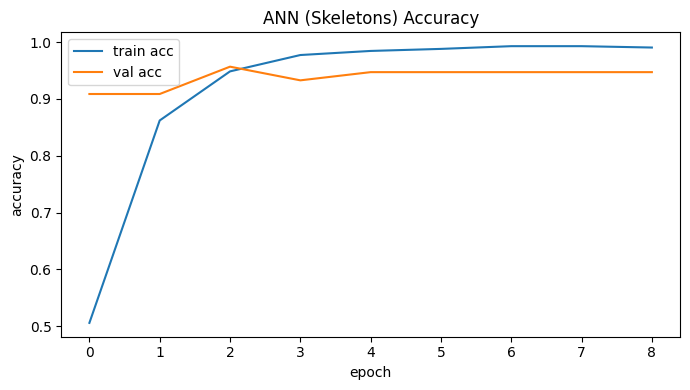

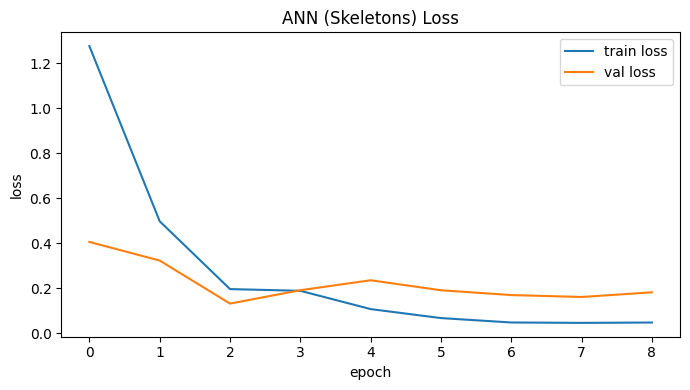

In [ ]:
# Cell 7 — ANN model for skeletons
def build_ann_simple(input_shape, num_classes):
    return keras.Sequential([
        layers.Rescaling(1./255, input_shape=input_shape),
        layers.Flatten(),
        layers.Dense(256, activation="relu"),
        layers.Dropout(0.30),
        layers.Dense(128, activation="relu"),
        layers.Dropout(0.20),
        layers.Dense(num_classes, activation="softmax"),
    ], name="ANN_Simple_Skeletons")

ann_skel = build_ann_simple(IMG_SIZE + (3,), skel_num_classes)
ann_skel.compile(optimizer=keras.optimizers.Adam(3e-4),
                 loss="categorical_crossentropy", metrics=["accuracy"])
ann_skel.summary()

EPOCHS_ANN_SKEL = 20
callbacks = [
    keras.callbacks.ModelCheckpoint("ann_skeletons.keras", save_best_only=True, monitor="val_accuracy"),
    keras.callbacks.EarlyStopping(monitor="val_accuracy", patience=6, restore_best_weights=True),
    keras.callbacks.ReduceLROnPlateau(monitor="val_accuracy", factor=0.5, patience=3, verbose=1, min_lr=1e-6)
]

hist_ann_skel = ann_skel.fit(
    skel_train_ds, validation_data=skel_val_ds, epochs=EPOCHS_ANN_SKEL,
    callbacks=callbacks, verbose=1
)

plot_history(hist_ann_skel, "ANN (Skeletons)")


Saved: metrics_ann_skeletons/classification_report_ann_skeletons.csv | metrics_ann_skeletons/confusion_counts.csv | metrics_ann_skeletons/confusion_normalized.csv


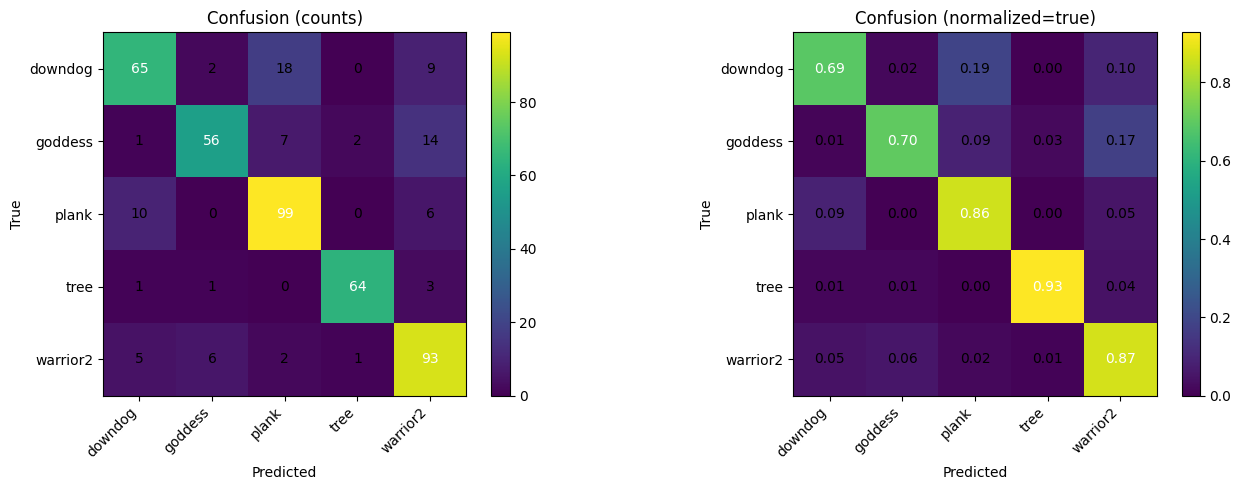

In [ ]:
# Cell 8 — evaluation & CSVs
_ = evaluate_cm_report(
    ann_skel, skel_test_ds, skel_class_names,
    out_dir="metrics_ann_skeletons",
    csv_name="classification_report_ann_skeletons.csv",
    normalize='true', zero_division=0
)


CNN

In [ ]:
# Only (re)define if missing in this runtime
import numpy as np, pandas as pd, matplotlib.pyplot as plt
from pathlib import Path
from sklearn.metrics import classification_report, confusion_matrix

try:
    plot_history
except NameError:
    def plot_history(history, title_prefix=""):
        h = history.history
        if "accuracy" in h:
            plt.figure(figsize=(7,4))
            plt.plot(h["accuracy"], label="train acc")
            if "val_accuracy" in h: plt.plot(h["val_accuracy"], label="val acc")
            plt.title(f"{title_prefix} Accuracy"); plt.xlabel("epoch"); plt.ylabel("accuracy")
            plt.legend(); plt.tight_layout(); plt.show()
        if "loss" in h:
            plt.figure(figsize=(7,4))
            plt.plot(h["loss"], label="train loss")
            if "val_loss" in h: plt.plot(h["val_loss"], label="val loss")
            plt.title(f"{title_prefix} Loss"); plt.xlabel("epoch"); plt.ylabel("loss")
            plt.legend(); plt.tight_layout(); plt.show()

try:
    evaluate_cm_report
except NameError:
    def evaluate_cm_report(model, dataset, class_names, out_dir,
                           csv_name="classification_report.csv", normalize='true', zero_division=0):
        out = Path(out_dir); out.mkdir(parents=True, exist_ok=True)
        # y_true (handles one-hot or int)
        y_true_batches = []
        for _, yb in dataset:
            yb = yb.numpy()
            y_true_batches.append(np.argmax(yb, axis=1) if yb.ndim == 2 else yb.astype(int))
        y_true = np.concatenate(y_true_batches, axis=0)
        # y_pred
        y_prob = model.predict(dataset, verbose=0)
        y_pred = np.argmax(y_prob, axis=1)
        # matrices
        labels = list(range(len(class_names)))
        cm  = confusion_matrix(y_true, y_pred, labels=labels)
        cmn = confusion_matrix(y_true, y_pred, labels=labels, normalize=normalize)
        # CSVs
        rep = classification_report(y_true, y_pred, target_names=class_names,
                                    output_dict=True, zero_division=zero_division)
        df_rep = pd.DataFrame(rep).transpose()
        df_rep.to_csv(out/csv_name, float_format="%.4f")
        pd.DataFrame(cm,  index=class_names, columns=class_names).to_csv(out/"confusion_counts.csv")
        pd.DataFrame(cmn, index=class_names, columns=class_names).to_csv(out/"confusion_normalized.csv", float_format="%.4f")
        print("Saved:", out/csv_name, "|", out/"confusion_counts.csv", "|", out/"confusion_normalized.csv")
        # quick plots
        fig, axes = plt.subplots(1,2, figsize=(14,5))
        im0 = axes[0].imshow(cm);  axes[0].set_title("Confusion (counts)")
        axes[0].set_xlabel("Predicted"); axes[0].set_ylabel("True")
        axes[0].set_xticks(range(len(class_names))); axes[0].set_yticks(range(len(class_names)))
        axes[0].set_xticklabels(class_names, rotation=45, ha='right'); axes[0].set_yticklabels(class_names)
        for i in range(cm.shape[0]):
            for j in range(cm.shape[1]):
                axes[0].text(j,i,int(cm[i,j]),ha='center',va='center',
                             color='white' if cm[i,j] > cm.max()/2 else 'black')
        plt.colorbar(im0, ax=axes[0], fraction=0.046, pad=0.04)

        im1 = axes[1].imshow(cmn); axes[1].set_title(f"Confusion (normalized={normalize})")
        axes[1].set_xlabel("Predicted"); axes[1].set_ylabel("True")
        axes[1].set_xticks(range(len(class_names))); axes[1].set_yticks(range(len(class_names)))
        axes[1].set_xticklabels(class_names, rotation=45, ha='right'); axes[1].set_yticklabels(class_names)
        for i in range(cmn.shape[0]):
            for j in range(cmn.shape[1]):
                axes[1].text(j,i,f"{cmn[i,j]:.2f}",ha='center',va='center',
                             color='white' if cmn[i,j] > cmn.max()/2 else 'black')
        plt.colorbar(im1, ax=axes[1], fraction=0.046, pad=0.04)
        plt.tight_layout(); plt.show()
        return df_rep, cm, cmn


In [ ]:
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers

# Optional: use your existing data_augment if it's in memory; otherwise define a tiny one here.
try:
    data_augment
except NameError:
    data_augment = keras.Sequential([
        layers.RandomFlip("horizontal"),
        layers.RandomRotation(0.08),
        layers.RandomZoom(0.10),
    ], name="augment")

def build_cnn_simple(input_shape, num_classes):
    inputs = keras.Input(shape=input_shape)
    x = data_augment(inputs)
    x = layers.Rescaling(1./255)(x)
    x = layers.Conv2D(32, 3, padding="same", activation="relu")(x); x = layers.MaxPool2D()(x)
    x = layers.Conv2D(64, 3, padding="same", activation="relu")(x); x = layers.MaxPool2D()(x)
    x = layers.Conv2D(128,3, padding="same", activation="relu")(x); x = layers.MaxPool2D()(x)
    x = layers.Dropout(0.25)(x)
    x = layers.GlobalAveragePooling2D()(x)
    x = layers.Dense(256, activation="relu")(x)
    x = layers.Dropout(0.30)(x)
    outputs = layers.Dense(num_classes, activation="softmax")(x)
    return keras.Model(inputs, outputs, name="CNN_Simple")


Model: "CNN_Simple"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ input_layer_2 (InputLayer)      │ (None, 224, 224, 3)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ augment (Sequential)            │ (None, 224, 224, 3)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ rescaling_2 (Rescaling)         │ (None, 224, 224, 3)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d (Conv2D)                 │ (None, 224, 224, 32)   │           896 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d (MaxPooling2D)    │ (None, 112, 112, 32)   │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_1 (Conv2D)               │ (None, 112, 112, 64)   │        18,496 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_1 (MaxPooling2D)  │ (None, 56, 56, 64)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_2 (Conv2D)               │ (None, 56, 56, 128)    │        73,856 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_2 (MaxPooling2D)  │ (None, 28, 28, 128)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_4 (Dropout)             │ (None, 28, 28, 128)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ global_average_pooling2d        │ (None, 128)            │             0 │
│ (GlobalAveragePooling2D)        │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_6 (Dense)                 │ (None, 256)            │        33,024 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_5 (Dropout)             │ (None, 256)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_7 (Dense)                 │ (None, 5)              │         1,285 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 127,557 (498.27 KB)

 Trainable params: 127,557 (498.27 KB)

 Non-trainable params: 0 (0.00 B)

Model object type: <class 'keras.src.models.functional.Functional'>
Model class name: Functional
Keras backend: tensorflow
Epoch 1/25
28/28 ━━━━━━━━━━━━━━━━━━━━ 10s 127ms/step - accuracy: 0.2474 - loss: 1.6056 - val_accuracy: 1.0000 - val_loss: 1.5142 - learning_rate: 0.0010
Epoch 2/25
28/28 ━━━━━━━━━━━━━━━━━━━━ 2s 80ms/step - accuracy: 0.2145 - loss: 1.5953 - val_accuracy: 0.1204 - val_loss: 1.4934 - learning_rate: 0.0010
Epoch 3/25
28/28 ━━━━━━━━━━━━━━━━━━━━ 3s 80ms/step - accuracy: 0.2651 - loss: 1.5903 - val_accuracy: 0.7454 - val_loss: 1.3707 - learning_rate: 0.0010
Epoch 4/25
27/28 ━━━━━━━━━━━━━━━━━━━━ 0s 78ms/step - accuracy: 0.2441 - loss: 1.5847
Epoch 4: ReduceLROnPlateau reducing learning rate to 0.0005000000237487257.
28/28 ━━━━━━━━━━━━━━━━━━━━ 2s 81ms/step - accuracy: 0.2436 - loss: 1.5850 - val_accuracy: 0.6991 - val_loss: 1.3140 - learning_rate: 0.0010
Epoch 5/25
28/28 ━━━━━━━━━━━━━━━━━━━━ 3s 82ms/step - accuracy: 0.2405 - loss: 1.5753 - val_accuracy: 0.5417 - val_loss: 1

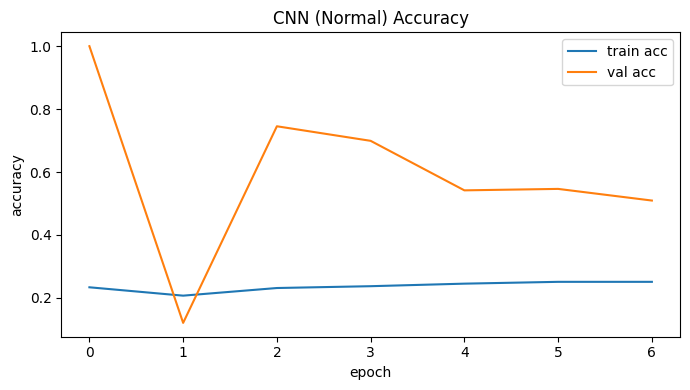

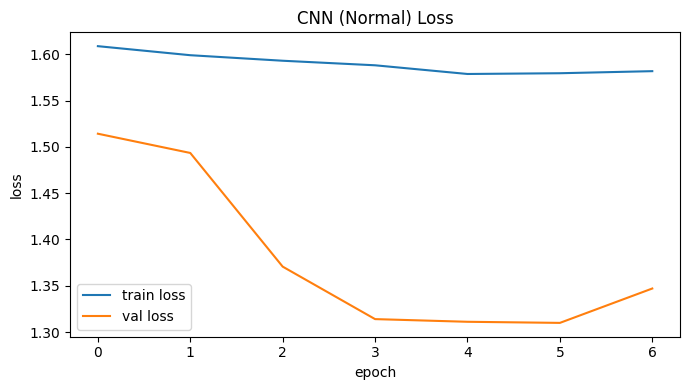

Saved: metrics_cnn_normal/classification_report_cnn_normal.csv | metrics_cnn_normal/confusion_counts.csv | metrics_cnn_normal/confusion_normalized.csv


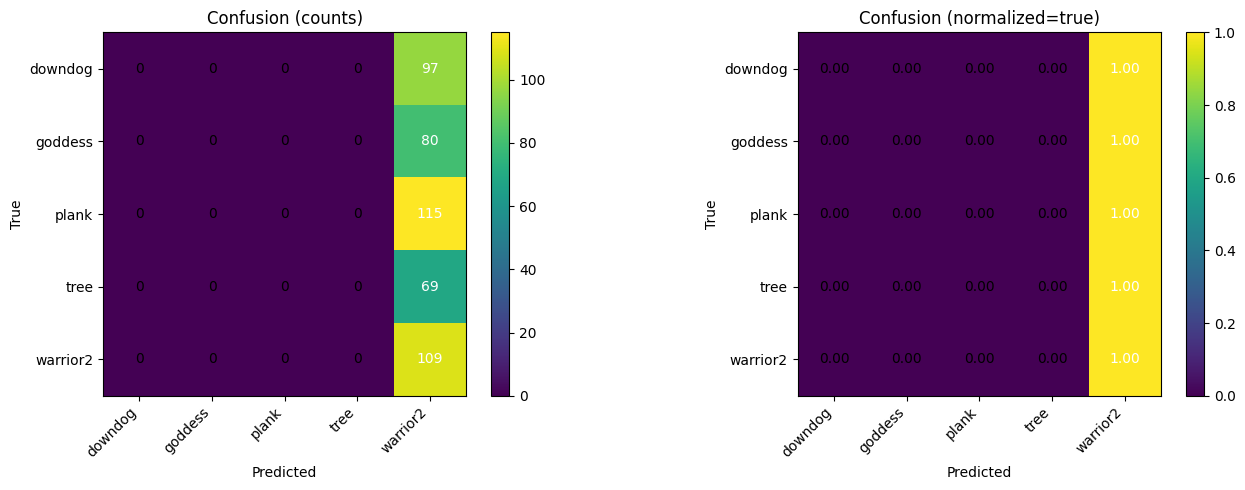

Planned epochs: 25 | Actual: 7


In [ ]:
# Assumes: IMG_SIZE, class_names, num_classes, train_ds, val_ds, test_ds already exist.
cnn_normal = build_cnn_simple(IMG_SIZE + (3,), num_classes)
cnn_normal.compile(optimizer=keras.optimizers.Adam(1e-3),
                   loss="categorical_crossentropy", metrics=["accuracy"])
cnn_normal.summary()

# Show "model type"
print("Model object type:", type(cnn_normal))
print("Model class name:", cnn_normal.__class__.__name__)
print("Keras backend:", tf.keras.backend.backend())

EPOCHS_CNN_NORMAL = 25
callbacks_cnn_normal = [
    keras.callbacks.ModelCheckpoint("cnn_normal.keras", save_best_only=True, monitor="val_accuracy"),
    keras.callbacks.EarlyStopping(monitor="val_accuracy", patience=6, restore_best_weights=True),
    keras.callbacks.ReduceLROnPlateau(monitor="val_accuracy", factor=0.5, patience=3, verbose=1, min_lr=1e-6),
]

hist_cnn_normal = cnn_normal.fit(
    train_ds, validation_data=val_ds, epochs=EPOCHS_CNN_NORMAL,
    callbacks=callbacks_cnn_normal, verbose=1
)

plot_history(hist_cnn_normal, title_prefix="CNN (Normal)")
_ = evaluate_cm_report(
    cnn_normal, test_ds, class_names,
    out_dir="metrics_cnn_normal",
    csv_name="classification_report_cnn_normal.csv",
    normalize='true', zero_division=0
)

print("Planned epochs:", EPOCHS_CNN_NORMAL, "| Actual:", len(hist_cnn_normal.epoch))


Model: "CNN_Simple"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ input_layer_4 (InputLayer)      │ (None, 224, 224, 3)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ augment (Sequential)            │ (None, 224, 224, 3)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ rescaling_3 (Rescaling)         │ (None, 224, 224, 3)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_3 (Conv2D)               │ (None, 224, 224, 32)   │           896 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_3 (MaxPooling2D)  │ (None, 112, 112, 32)   │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_4 (Conv2D)               │ (None, 112, 112, 64)   │        18,496 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_4 (MaxPooling2D)  │ (None, 56, 56, 64)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_5 (Conv2D)               │ (None, 56, 56, 128)    │        73,856 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_5 (MaxPooling2D)  │ (None, 28, 28, 128)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_6 (Dropout)             │ (None, 28, 28, 128)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ global_average_pooling2d_1      │ (None, 128)            │             0 │
│ (GlobalAveragePooling2D)        │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_8 (Dense)                 │ (None, 256)            │        33,024 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_7 (Dropout)             │ (None, 256)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_9 (Dense)                 │ (None, 5)              │         1,285 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 127,557 (498.27 KB)

 Trainable params: 127,557 (498.27 KB)

 Non-trainable params: 0 (0.00 B)

Model object type: <class 'keras.src.models.functional.Functional'>
Model class name: Functional
Keras backend: tensorflow
Epoch 1/25
27/27 ━━━━━━━━━━━━━━━━━━━━ 5s 98ms/step - accuracy: 0.2494 - loss: 1.5987 - val_accuracy: 0.0000e+00 - val_loss: 1.5086 - learning_rate: 0.0010
Epoch 2/25
27/27 ━━━━━━━━━━━━━━━━━━━━ 2s 81ms/step - accuracy: 0.2440 - loss: 1.5911 - val_accuracy: 0.4904 - val_loss: 1.3758 - learning_rate: 0.0010
Epoch 3/25
27/27 ━━━━━━━━━━━━━━━━━━━━ 3s 80ms/step - accuracy: 0.2639 - loss: 1.5763 - val_accuracy: 0.7933 - val_loss: 1.2763 - learning_rate: 0.0010
Epoch 4/25
27/27 ━━━━━━━━━━━━━━━━━━━━ 2s 77ms/step - accuracy: 0.3017 - loss: 1.5627 - val_accuracy: 0.8173 - val_loss: 1.1593 - learning_rate: 0.0010
Epoch 5/25
27/27 ━━━━━━━━━━━━━━━━━━━━ 3s 77ms/step - accuracy: 0.2959 - loss: 1.5334 - val_accuracy: 0.8894 - val_loss: 0.7823 - learning_rate: 0.0010
Epoch 6/25
27/27 ━━━━━━━━━━━━━━━━━━━━ 2s 74ms/step - accuracy: 0.3621 - loss: 1.4836 - val_accuracy: 0.7885 - val_loss

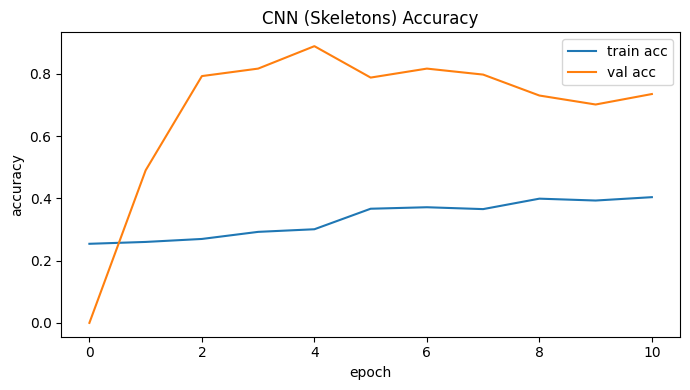

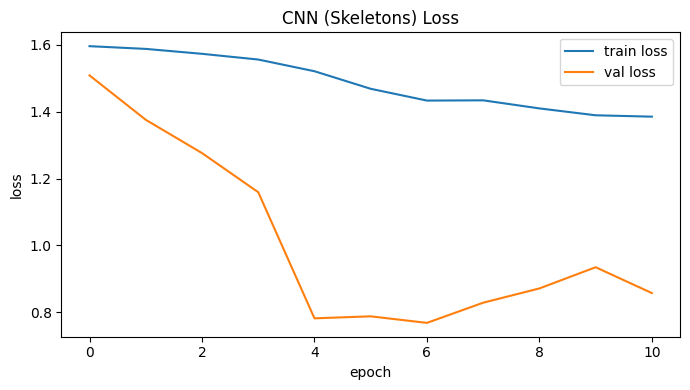

Saved: metrics_cnn_skeletons/classification_report_cnn_skeletons.csv | metrics_cnn_skeletons/confusion_counts.csv | metrics_cnn_skeletons/confusion_normalized.csv


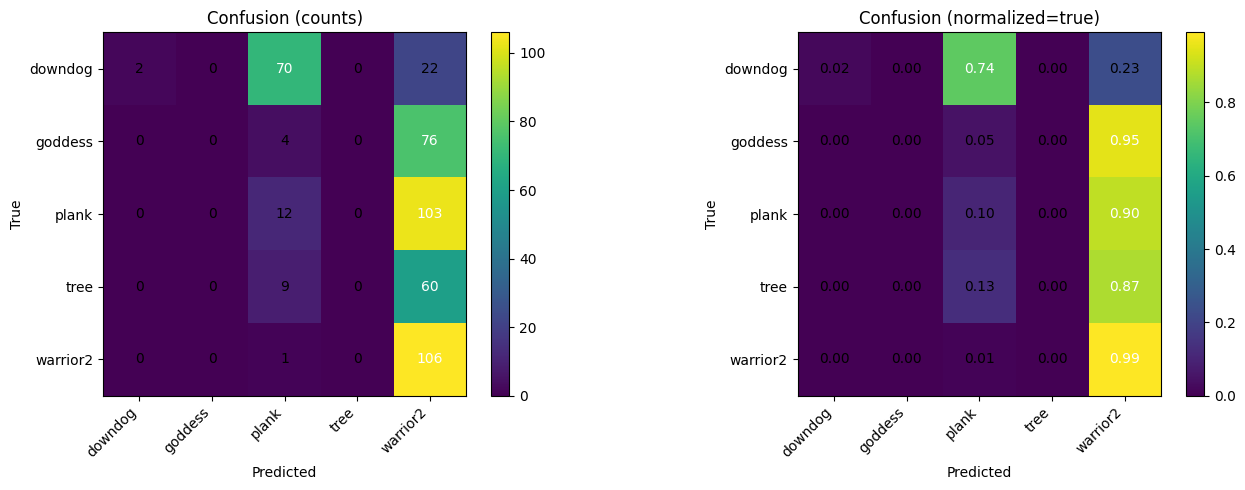

Planned epochs: 25 | Actual: 11


In [ ]:
# Assumes: skel_train_ds, skel_val_ds, skel_test_ds, skel_class_names, skel_num_classes, IMG_SIZE exist.
cnn_skel = build_cnn_simple(IMG_SIZE + (3,), skel_num_classes)
cnn_skel.compile(optimizer=keras.optimizers.Adam(1e-3),
                 loss="categorical_crossentropy", metrics=["accuracy"])
cnn_skel.summary()

# Show "model type"
print("Model object type:", type(cnn_skel))
print("Model class name:", cnn_skel.__class__.__name__)
print("Keras backend:", tf.keras.backend.backend())

EPOCHS_CNN_SKEL = 25
callbacks_cnn_skel = [
    keras.callbacks.ModelCheckpoint("cnn_skeletons.keras", save_best_only=True, monitor="val_accuracy"),
    keras.callbacks.EarlyStopping(monitor="val_accuracy", patience=6, restore_best_weights=True),
    keras.callbacks.ReduceLROnPlateau(monitor="val_accuracy", factor=0.5, patience=3, verbose=1, min_lr=1e-6),
]

hist_cnn_skel = cnn_skel.fit(
    skel_train_ds, validation_data=skel_val_ds, epochs=EPOCHS_CNN_SKEL,
    callbacks=callbacks_cnn_skel, verbose=1
)

plot_history(hist_cnn_skel, title_prefix="CNN (Skeletons)")
_ = evaluate_cm_report(
    cnn_skel, skel_test_ds, skel_class_names,
    out_dir="metrics_cnn_skeletons",
    csv_name="classification_report_cnn_skeletons.csv",
    normalize='true', zero_division=0
)

print("Planned epochs:", EPOCHS_CNN_SKEL, "| Actual:", len(hist_cnn_skel.epoch))


MobileNetV3

12683000/12683000 ━━━━━━━━━━━━━━━━━━━━ 2s 0us/step


Model: "MobileNetV3Large_RGB"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ input_layer_6 (InputLayer)      │ (None, 224, 224, 3)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ augment (Sequential)            │ (None, 224, 224, 3)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ MobileNetV3Large (Functional)   │ (None, 7, 7, 960)      │     2,996,352 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ global_average_pooling2d_2      │ (None, 960)            │             0 │
│ (GlobalAveragePooling2D)        │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_8 (Dropout)             │ (None, 960)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_10 (Dense)                │ (None, 5)              │         4,805 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 3,001,157 (11.45 MB)

 Trainable params: 4,805 (18.77 KB)

 Non-trainable params: 2,996,352 (11.43 MB)

Model object type: <class 'keras.src.models.functional.Functional'> | class: Functional
Epoch 1/12
28/28 ━━━━━━━━━━━━━━━━━━━━ 15s 272ms/step - accuracy: 0.2172 - loss: 2.1860 - val_accuracy: 0.2222 - val_loss: 1.7553 - learning_rate: 0.0010
Epoch 2/12
28/28 ━━━━━━━━━━━━━━━━━━━━ 2s 82ms/step - accuracy: 0.4475 - loss: 1.4120 - val_accuracy: 0.5046 - val_loss: 1.1281 - learning_rate: 0.0010
Epoch 3/12
28/28 ━━━━━━━━━━━━━━━━━━━━ 2s 75ms/step - accuracy: 0.5600 - loss: 1.1155 - val_accuracy: 0.7222 - val_loss: 0.8776 - learning_rate: 0.0010
Epoch 4/12
28/28 ━━━━━━━━━━━━━━━━━━━━ 2s 81ms/step - accuracy: 0.6305 - loss: 0.9762 - val_accuracy: 0.7685 - val_loss: 0.7322 - learning_rate: 0.0010
Epoch 5/12
28/28 ━━━━━━━━━━━━━━━━━━━━ 2s 80ms/step - accuracy: 0.6884 - loss: 0.8216 - val_accuracy: 0.7731 - val_loss: 0.7040 - learning_rate: 0.0010
Epoch 6/12
28/28 ━━━━━━━━━━━━━━━━━━━━ 2s 75ms/step - accuracy: 0.7487 - loss: 0.7213 - val_accuracy: 0.8287 - val_loss: 0.5809 - learning_rate: 0.0010
Epoc

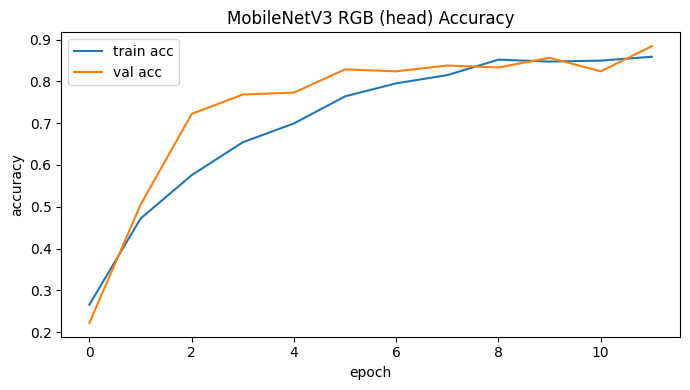

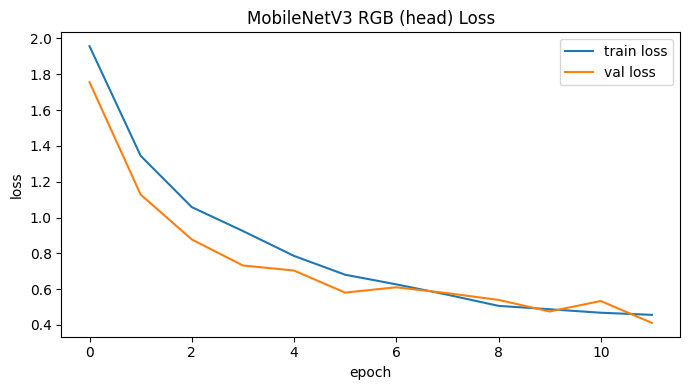

Saved: metrics_mnv3_rgb_head/classification_report_mnv3_rgb_head.csv | metrics_mnv3_rgb_head/confusion_counts.csv | metrics_mnv3_rgb_head/confusion_normalized.csv


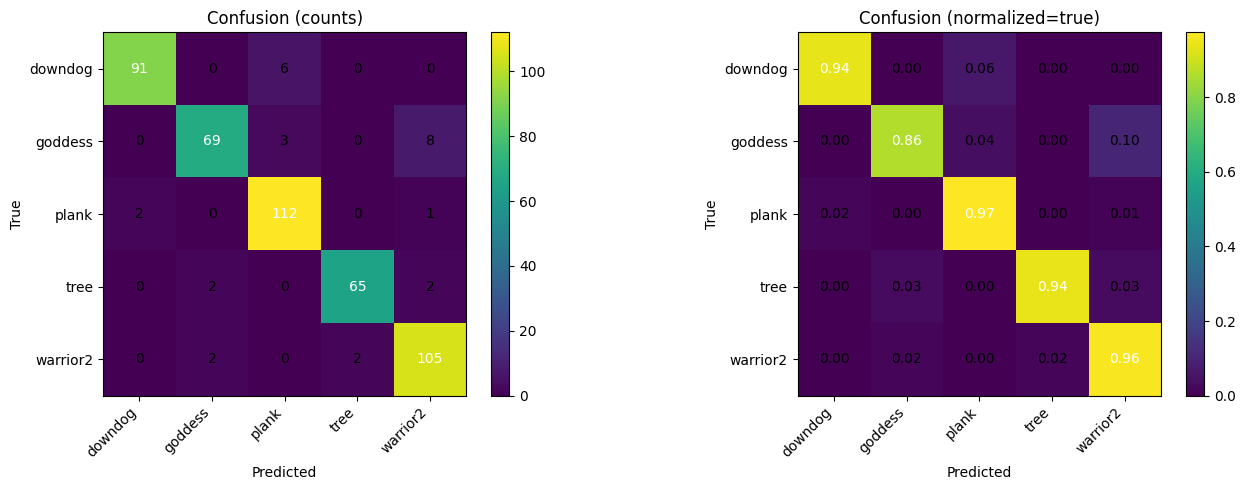

In [ ]:
from tensorflow import keras
from tensorflow.keras import layers
from tensorflow.keras.applications import MobileNetV3Large

# Data augmentation (reuse if you already have one)
try:
    data_augment
except NameError:
    data_augment = keras.Sequential([
        layers.RandomFlip("horizontal"),
        layers.RandomRotation(0.08),
        layers.RandomZoom(0.10),
    ], name="augment")

# Base: pretrained ImageNet, no top, with built-in preprocessing (expects 0..255)
mnv3_base = MobileNetV3Large(
    input_shape=IMG_SIZE + (3,),
    include_top=False,
    weights="imagenet",
    include_preprocessing=True,
)
mnv3_base.trainable = False  # freeze for head training

inputs = keras.Input(shape=IMG_SIZE + (3,))
x = data_augment(inputs)
# IMPORTANT: do NOT add layers.Rescaling(1./255) because include_preprocessing=True
x = mnv3_base(x, training=False)
x = layers.GlobalAveragePooling2D()(x)
x = layers.Dropout(0.2)(x)
outputs = layers.Dense(num_classes, activation="softmax")(x)

mnv3_rgb = keras.Model(inputs, outputs, name="MobileNetV3Large_RGB")
mnv3_rgb.compile(optimizer=keras.optimizers.Adam(1e-3),
                 loss="categorical_crossentropy",
                 metrics=["accuracy"])
mnv3_rgb.summary()
print("Model object type:", type(mnv3_rgb), "| class:", mnv3_rgb.__class__.__name__)

EPOCHS_HEAD = 12
cb_head = [
    keras.callbacks.ModelCheckpoint("mnv3_rgb_head.keras", save_best_only=True, monitor="val_accuracy"),
    keras.callbacks.EarlyStopping(monitor="val_accuracy", patience=5, restore_best_weights=True),
    keras.callbacks.ReduceLROnPlateau(monitor="val_accuracy", factor=0.5, patience=2, min_lr=1e-6, verbose=1),
]
hist_mnv3_rgb_head = mnv3_rgb.fit(train_ds, validation_data=val_ds, epochs=EPOCHS_HEAD, callbacks=cb_head, verbose=1)

plot_history(hist_mnv3_rgb_head, "MobileNetV3 RGB (head)")
_ = evaluate_cm_report(
    mnv3_rgb, test_ds, class_names,
    out_dir="metrics_mnv3_rgb_head",
    csv_name="classification_report_mnv3_rgb_head.csv",
    normalize='true', zero_division=0
)


Epoch 1/15
28/28 ━━━━━━━━━━━━━━━━━━━━ 14s 166ms/step - accuracy: 0.8468 - loss: 0.4518 - val_accuracy: 0.8843 - val_loss: 0.4077 - learning_rate: 1.0000e-05
Epoch 2/15
28/28 ━━━━━━━━━━━━━━━━━━━━ 2s 72ms/step - accuracy: 0.8603 - loss: 0.3974 - val_accuracy: 0.8796 - val_loss: 0.4105 - learning_rate: 1.0000e-05
Epoch 3/15
27/28 ━━━━━━━━━━━━━━━━━━━━ 0s 63ms/step - accuracy: 0.8713 - loss: 0.3881
Epoch 3: ReduceLROnPlateau reducing learning rate to 4.999999873689376e-06.
28/28 ━━━━━━━━━━━━━━━━━━━━ 2s 72ms/step - accuracy: 0.8721 - loss: 0.3860 - val_accuracy: 0.8750 - val_loss: 0.4222 - learning_rate: 1.0000e-05
Epoch 4/15
28/28 ━━━━━━━━━━━━━━━━━━━━ 2s 77ms/step - accuracy: 0.8769 - loss: 0.3692 - val_accuracy: 0.8750 - val_loss: 0.4112 - learning_rate: 5.0000e-06
Epoch 5/15
28/28 ━━━━━━━━━━━━━━━━━━━━ 3s 100ms/step - accuracy: 0.9086 - loss: 0.3401 - val_accuracy: 0.8889 - val_loss: 0.3952 - learning_rate: 5.0000e-06
Epoch 6/15
28/28 ━━━━━━━━━━━━━━━━━━━━ 2s 74ms/step - accuracy: 0.8781 - 

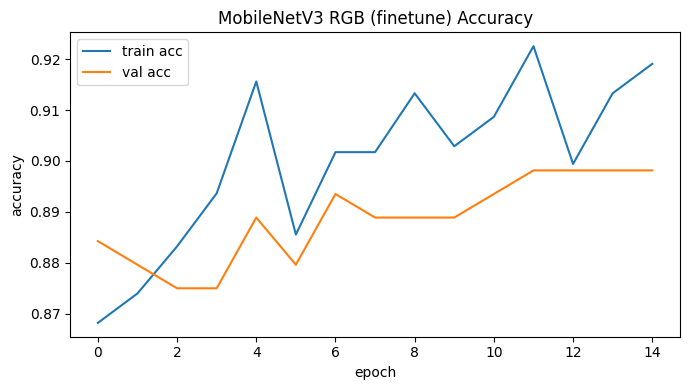

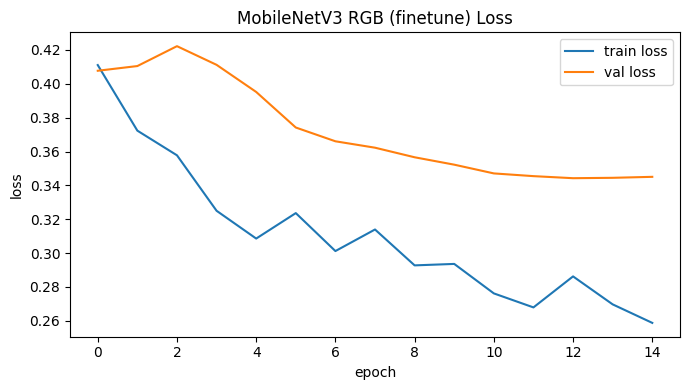

Saved: metrics_mnv3_rgb_finetune/classification_report_mnv3_rgb_finetune.csv | metrics_mnv3_rgb_finetune/confusion_counts.csv | metrics_mnv3_rgb_finetune/confusion_normalized.csv


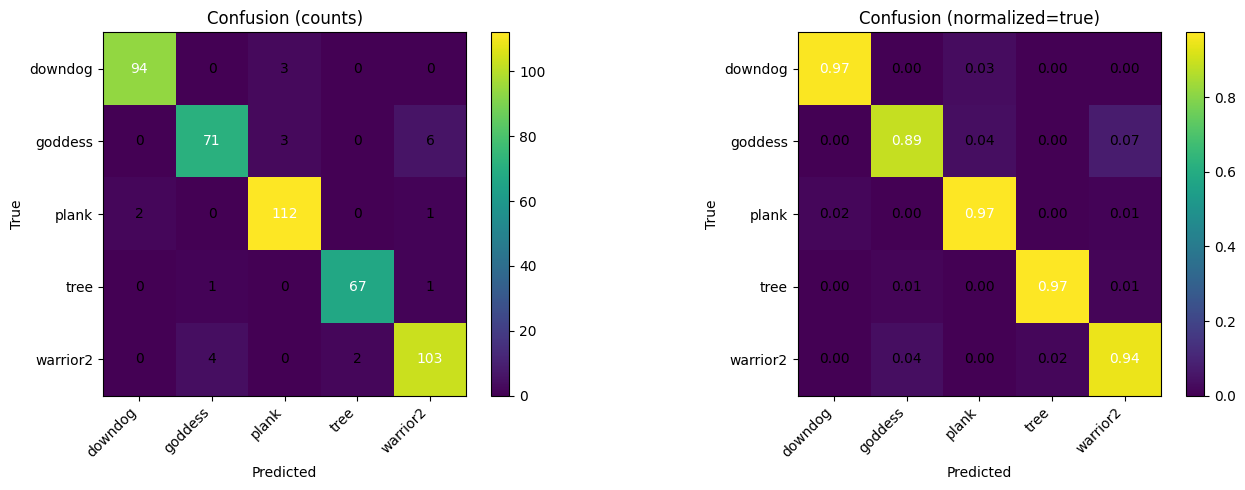

In [ ]:
# Unfreeze last ~50 layers (tune this) but keep BatchNorm frozen
from tensorflow.keras.layers import BatchNormalization

mnv3_base.trainable = True
FINE_TUNE_AT = max(0, len(mnv3_base.layers) - 50)
for i, layer in enumerate(mnv3_base.layers):
    if i < FINE_TUNE_AT:
        layer.trainable = False
    else:
        # keep BN layers frozen for stable fine-tuning
        if isinstance(layer, BatchNormalization):
            layer.trainable = False
        else:
            layer.trainable = True

mnv3_rgb.compile(optimizer=keras.optimizers.Adam(1e-5),
                 loss="categorical_crossentropy",
                 metrics=["accuracy"])

EPOCHS_FT = 15
cb_ft = [
    keras.callbacks.ModelCheckpoint("mnv3_rgb_finetuned.keras", save_best_only=True, monitor="val_accuracy"),
    keras.callbacks.EarlyStopping(monitor="val_accuracy", patience=6, restore_best_weights=True),
    keras.callbacks.ReduceLROnPlateau(monitor="val_accuracy", factor=0.5, patience=2, min_lr=1e-6, verbose=1),
]
hist_mnv3_rgb_ft = mnv3_rgb.fit(train_ds, validation_data=val_ds, epochs=EPOCHS_FT, callbacks=cb_ft, verbose=1)

plot_history(hist_mnv3_rgb_ft, "MobileNetV3 RGB (finetune)")
_ = evaluate_cm_report(
    mnv3_rgb, test_ds, class_names,
    out_dir="metrics_mnv3_rgb_finetune",
    csv_name="classification_report_mnv3_rgb_finetune.csv",
    normalize='true', zero_division=0
)


Model: "MobileNetV3Large_Skeletons"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ input_layer_8 (InputLayer)      │ (None, 224, 224, 3)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ augment (Sequential)            │ (None, 224, 224, 3)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ MobileNetV3Large (Functional)   │ (None, 7, 7, 960)      │     2,996,352 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ global_average_pooling2d_3      │ (None, 960)            │             0 │
│ (GlobalAveragePooling2D)        │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_9 (Dropout)             │ (None, 960)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_11 (Dense)                │ (None, 5)              │         4,805 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 3,001,157 (11.45 MB)

 Trainable params: 4,805 (18.77 KB)

 Non-trainable params: 2,996,352 (11.43 MB)

Model object type: <class 'keras.src.models.functional.Functional'> | class: Functional
Epoch 1/12
27/27 ━━━━━━━━━━━━━━━━━━━━ 11s 202ms/step - accuracy: 0.2609 - loss: 1.8985 - val_accuracy: 0.7260 - val_loss: 0.9015 - learning_rate: 0.0010
Epoch 2/12
27/27 ━━━━━━━━━━━━━━━━━━━━ 1s 53ms/step - accuracy: 0.5662 - loss: 1.0943 - val_accuracy: 0.7067 - val_loss: 0.7972 - learning_rate: 0.0010
Epoch 3/12
27/27 ━━━━━━━━━━━━━━━━━━━━ 2s 74ms/step - accuracy: 0.6598 - loss: 0.8643 - val_accuracy: 0.7452 - val_loss: 0.7609 - learning_rate: 0.0010
Epoch 4/12
27/27 ━━━━━━━━━━━━━━━━━━━━ 2s 75ms/step - accuracy: 0.7273 - loss: 0.7119 - val_accuracy: 0.7933 - val_loss: 0.6228 - learning_rate: 0.0010
Epoch 5/12
27/27 ━━━━━━━━━━━━━━━━━━━━ 2s 75ms/step - accuracy: 0.7860 - loss: 0.6286 - val_accuracy: 0.7981 - val_loss: 0.5996 - learning_rate: 0.0010
Epoch 6/12
27/27 ━━━━━━━━━━━━━━━━━━━━ 2s 86ms/step - accuracy: 0.8117 - loss: 0.5684 - val_accuracy: 0.8462 - val_loss: 0.4945 - learning_rate: 0.0010
Epoc

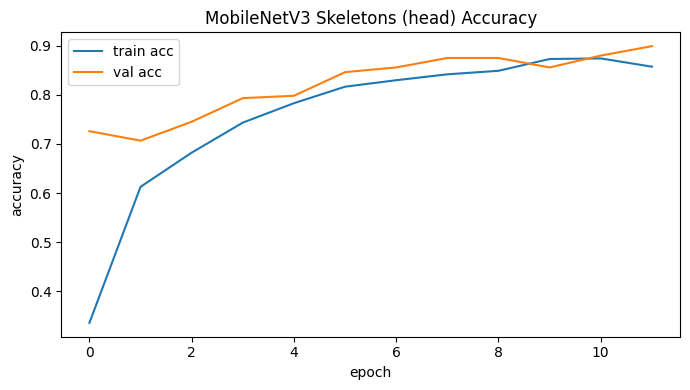

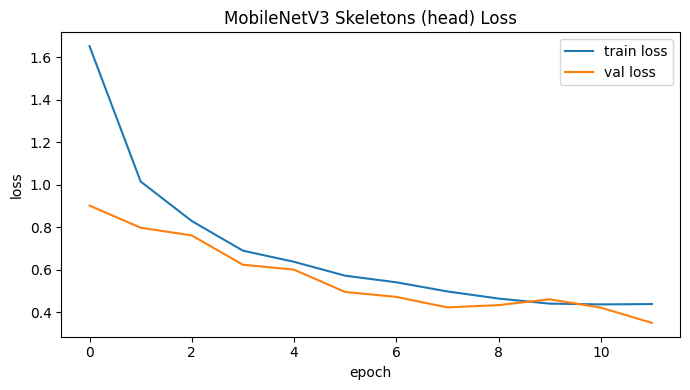

Saved: metrics_mnv3_skeletons_head/classification_report_mnv3_skeletons_head.csv | metrics_mnv3_skeletons_head/confusion_counts.csv | metrics_mnv3_skeletons_head/confusion_normalized.csv


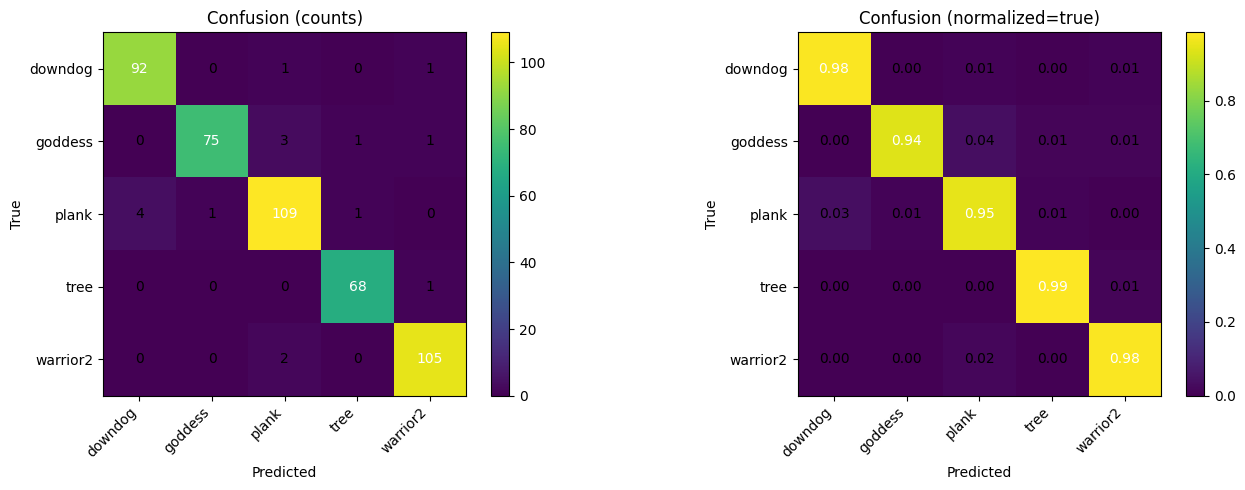

In [ ]:
from tensorflow.keras.applications import MobileNetV3Large

mnv3_skel_base = MobileNetV3Large(
    input_shape=IMG_SIZE + (3,),
    include_top=False,
    weights="imagenet",
    include_preprocessing=True,  # handles 0..255 inside the model
)
mnv3_skel_base.trainable = False

inp_s = keras.Input(shape=IMG_SIZE + (3,))
xs = data_augment(inp_s)             # light aug still helps even on skeletons
xs = mnv3_skel_base(xs, training=False)
xs = layers.GlobalAveragePooling2D()(xs)
xs = layers.Dropout(0.2)(xs)
outs_s = layers.Dense(skel_num_classes, activation="softmax")(xs)

mnv3_skel = keras.Model(inp_s, outs_s, name="MobileNetV3Large_Skeletons")
mnv3_skel.compile(optimizer=keras.optimizers.Adam(1e-3),
                  loss="categorical_crossentropy",
                  metrics=["accuracy"])
mnv3_skel.summary()
print("Model object type:", type(mnv3_skel), "| class:", mnv3_skel.__class__.__name__)

EPOCHS_SKEL_HEAD = 12
cb_skel_head = [
    keras.callbacks.ModelCheckpoint("mnv3_skeletons_head.keras", save_best_only=True, monitor="val_accuracy"),
    keras.callbacks.EarlyStopping(monitor="val_accuracy", patience=5, restore_best_weights=True),
    keras.callbacks.ReduceLROnPlateau(monitor="val_accuracy", factor=0.5, patience=2, min_lr=1e-6, verbose=1),
]
hist_mnv3_skel_head = mnv3_skel.fit(skel_train_ds, validation_data=skel_val_ds, epochs=EPOCHS_SKEL_HEAD, callbacks=cb_skel_head, verbose=1)

plot_history(hist_mnv3_skel_head, "MobileNetV3 Skeletons (head)")
_ = evaluate_cm_report(
    mnv3_skel, skel_test_ds, skel_class_names,
    out_dir="metrics_mnv3_skeletons_head",
    csv_name="classification_report_mnv3_skeletons_head.csv",
    normalize='true', zero_division=0
)


Epoch 1/15
27/27 ━━━━━━━━━━━━━━━━━━━━ 14s 210ms/step - accuracy: 0.8858 - loss: 0.3881 - val_accuracy: 0.8654 - val_loss: 0.4067 - learning_rate: 1.0000e-05
Epoch 2/15
27/27 ━━━━━━━━━━━━━━━━━━━━ 3s 99ms/step - accuracy: 0.8684 - loss: 0.3798 - val_accuracy: 0.8798 - val_loss: 0.3680 - learning_rate: 1.0000e-05
Epoch 3/15
27/27 ━━━━━━━━━━━━━━━━━━━━ 2s 74ms/step - accuracy: 0.9101 - loss: 0.3280 - val_accuracy: 0.8798 - val_loss: 0.3798 - learning_rate: 1.0000e-05
Epoch 4/15
27/27 ━━━━━━━━━━━━━━━━━━━━ 3s 97ms/step - accuracy: 0.9039 - loss: 0.3160 - val_accuracy: 0.9135 - val_loss: 0.3341 - learning_rate: 1.0000e-05
Epoch 5/15
27/27 ━━━━━━━━━━━━━━━━━━━━ 2s 73ms/step - accuracy: 0.9154 - loss: 0.2987 - val_accuracy: 0.8798 - val_loss: 0.3753 - learning_rate: 1.0000e-05
Epoch 6/15
27/27 ━━━━━━━━━━━━━━━━━━━━ 3s 102ms/step - accuracy: 0.9139 - loss: 0.2909 - val_accuracy: 0.9231 - val_loss: 0.2952 - learning_rate: 1.0000e-05
Epoch 7/15
27/27 ━━━━━━━━━━━━━━━━━━━━ 2s 74ms/step - accuracy: 0.91

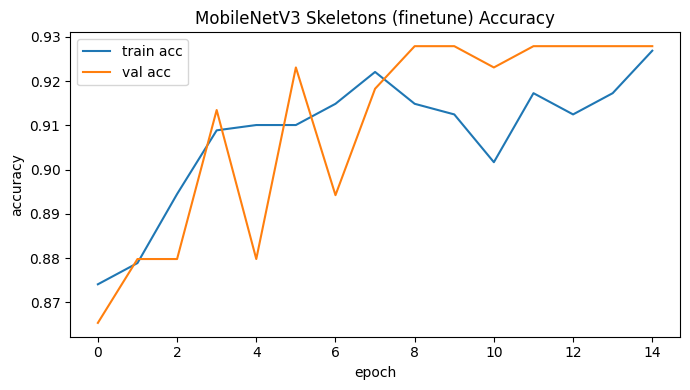

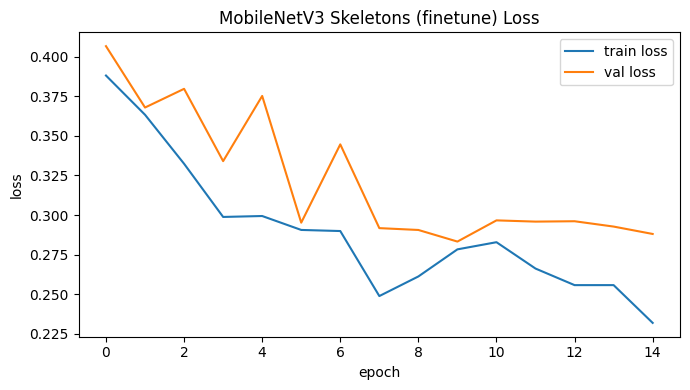

Saved: metrics_mnv3_skeletons_finetune/classification_report_mnv3_skeletons_finetune.csv | metrics_mnv3_skeletons_finetune/confusion_counts.csv | metrics_mnv3_skeletons_finetune/confusion_normalized.csv


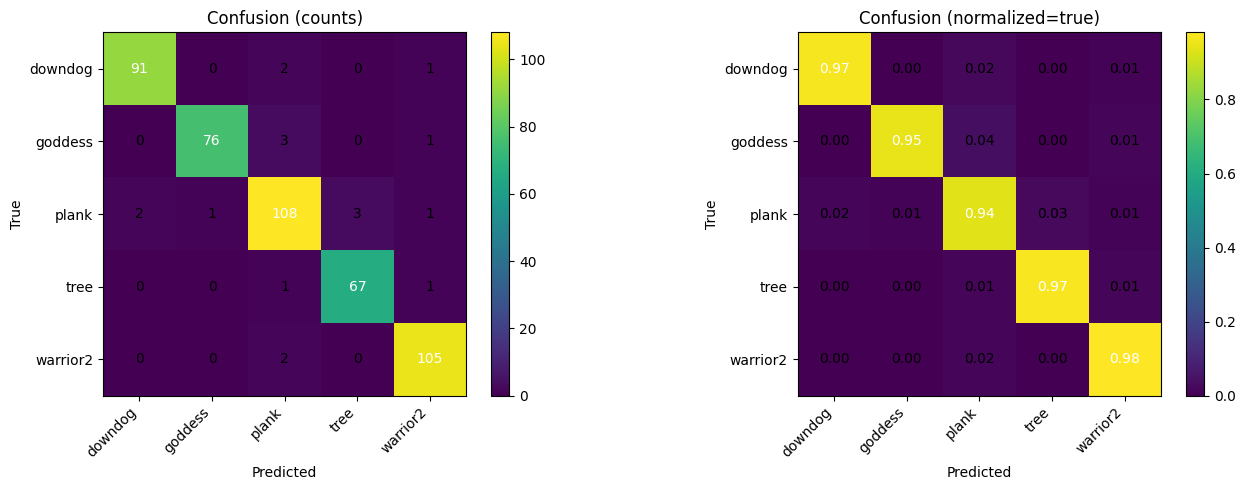

In [ ]:
from tensorflow.keras.layers import BatchNormalization

mnv3_skel_base.trainable = True
FINE_TUNE_AT_SKEL = max(0, len(mnv3_skel_base.layers) - 50)
for i, layer in enumerate(mnv3_skel_base.layers):
    if i < FINE_TUNE_AT_SKEL:
        layer.trainable = False
    else:
        if isinstance(layer, BatchNormalization):
            layer.trainable = False
        else:
            layer.trainable = True

mnv3_skel.compile(optimizer=keras.optimizers.Adam(1e-5),
                  loss="categorical_crossentropy",
                  metrics=["accuracy"])

EPOCHS_SKEL_FT = 15
cb_skel_ft = [
    keras.callbacks.ModelCheckpoint("mnv3_skeletons_finetuned.keras", save_best_only=True, monitor="val_accuracy"),
    keras.callbacks.EarlyStopping(monitor="val_accuracy", patience=6, restore_best_weights=True),
    keras.callbacks.ReduceLROnPlateau(monitor="val_accuracy", factor=0.5, patience=2, min_lr=1e-6, verbose=1),
]
hist_mnv3_skel_ft = mnv3_skel.fit(skel_train_ds, validation_data=skel_val_ds, epochs=EPOCHS_SKEL_FT, callbacks=cb_skel_ft, verbose=1)

plot_history(hist_mnv3_skel_ft, "MobileNetV3 Skeletons (finetune)")
_ = evaluate_cm_report(
    mnv3_skel, skel_test_ds, skel_class_names,
    out_dir="metrics_mnv3_skeletons_finetune",
    csv_name="classification_report_mnv3_skeletons_finetune.csv",
    normalize='true', zero_division=0
)
